## Explainability of Attention Mechanisms in `t2` with Z Features. Add to L.

This notebook looks at the attention responses for a given input and tries to explore the explainability of the attention mechanism that is being used in the `t2` model

In [5]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.ticker as ticker

from matplotlib import rcParams
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from astronet.constants import astronet_working_directory as asnwd
from astronet.t2.model import T2Model
from astronet.utils import astronet_logger, load_dataset, find_optimal_batch_size
from astronet.visualise_results import (
    plot_acc_history,
    plot_confusion_matrix,
    plot_loss_history,
    plot_multiROC,
    _get_encoding,
)

tf.get_logger().setLevel('ERROR')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

import random as python_random
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(RANDOM_SEED)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"]})

plt.rcParams["figure.figsize"] = (20,3)
mpl.rc('axes', labelsize=22)
mpl.rc('xtick', labelsize=28)
mpl.rc('ytick', labelsize=28)


print(plt.style.available)

mpl.style.use("seaborn-whitegrid")

architecture = "t2"

dataset = "plasticc"

snonly = None

if snonly is not None:
    dataform = "snonly"
else:
    dataform = "full"

# X_train, y_train, X_test, y_test, loss, Z_train, Z_test = load_dataset(
#     dataset, redshift=True, snonly=snonly, testset=None,
# )

X_test = np.load(
        f"{asnwd}/data/plasticc/test_set/infer/X_test.npy",
)
y_test = np.load(
        f"{asnwd}/data/plasticc/test_set/infer/y_test.npy",
)
Z_test = np.load(
        f"{asnwd}/data/plasticc/test_set/infer/Z_test.npy",
)

num_classes = y_test.shape[1]
print(num_classes)

BATCH_SIZE = find_optimal_batch_size(X_test.shape[0])
_, timesteps, num_features = X_test.shape  # X_train.shape[1:] == (TIMESTEPS, num_features)
input_shape = (BATCH_SIZE, timesteps, num_features)
print(input_shape)

_, num_z_features = Z_test.shape
Z_input_shape = (BATCH_SIZE, num_z_features)

model_name = "1619624444-0.1.dev765+g7c90cbb.d20210428"

with open(f"{asnwd}/astronet/{architecture}/models/{dataset}/results_with_z.json") as f:
    events = json.load(f)
    if model_name is not None:
    # Get params for model chosen with cli args
        event = next(item for item in events['training_result'] if item["name"] == model_name)
    else:
        # Get params for best model with lowest loss
        event = min(
            (item for item in events["training_result"] if item["augmented"] is None),
                key=lambda ev: ev["model_evaluate_on_test_loss"],
            )

#         event = min(events['training_result'], key=lambda ev: ev['model_evaluate_on_test_loss'])

model_name = event['name']

embed_dim = event['embed_dim']  # --> Embedding size for each token
num_heads = event['num_heads']  # --> Number of attention heads
ff_dim = event['ff_dim']  # --> Hidden layer size in feed forward network inside transformer

# --> Number of filters to use in ConvEmbedding block, should be equal to embed_dim
num_filters = embed_dim

num_layers = event['num_layers']    # --> N x repeated transformer blocks
droprate = event['droprate']        # --> Rate of neurons to drop

input_shape_nobatch = input_shape[1:]
Z_input_shape_nobatch = Z_input_shape[1:]

inputs = [
    tf.keras.Input(shape=input_shape_nobatch),
    tf.keras.Input(shape=Z_input_shape_nobatch),
]

# input_shape_nobatch = input_shape[1:]
# inputs = tf.keras.Input(shape=input_shape_nobatch)

print(input_shape_nobatch, Z_input_shape_nobatch)
print(input_shape)

print(inputs)

tf.config.run_functions_eagerly(True)

model = T2Model(
    input_dim=input_shape,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_filters=num_filters,
    num_classes=num_classes,
    num_layers=num_layers,
    droprate=droprate,
    num_aux_feats=2,
    add_aux_feats_to="L",
)

model.call(inputs, training=True)
model.build(input_shape)
print(model.summary())

model.load_weights(f"{asnwd}/astronet/{architecture}/models/{dataset}/model-{model_name}")

print(model.layers)

for i in model.layers:
    print(i.output)

encoding, class_encoding, class_names = _get_encoding(dataset, dataform=dataform)
class_mapping = {
    90: "SNIa",
    67: "SNIa-91bg",
    52: "SNIax",
    42: "SNII",
    62: "SNIbc",
    95: "SLSN-I",
    15: "TDE",
    64: "KN",
    88: "AGN",
    92: "RRL",
    65: "M-dwarf",
    16: "EB",
    53: "Mira",
    6: "$\mu$-Lens-Single",
}
class_encoding
class_names = list(np.vectorize(class_mapping.get)(class_encoding))
print(class_names)

for i in range(len(model.layers)):
    print(i, model.layers[i].name)

from keras.models import Model
# same as previous model but with an additional output
cam_model = Model(inputs=inputs,outputs=(model.layers[2].output,model.layers[5].output), name="CAM")
print(cam_model.summary())

# get the features and results of the test images using the newly created model
features,results = cam_model.predict([X_test, Z_test])

# shape of the features
print("features shape: ", features.shape)
print("results shape", results.shape)

# these are the weights going into the softmax layer
last_dense_layer = model.layers[-1]

# get the weights list.  index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

# shows the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

print(features.shape)

# Get the features for the image at index 0
idx = 0
features_for_img = features[idx,:,:]

print(f"The features for image index {idx} has shape (timesteps, num of feature channels) : ", features_for_img.shape)

# Select the weights that are used for a specific class (0...9)
class_id = 0
# take the dot product between the scaled image features and the weights for
gap_weights_for_one_class = gap_weights[:,class_id]

print("features_for_img_scaled has shape ", features_for_img.shape)
print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)
# take the dot product between the scaled features and the weights for one class
cam = np.dot(features_for_img, gap_weights_for_one_class)
print("class activation map shape ", cam.shape)

cam_all = np.dot(features, gap_weights)
print("all class activation map shape ", cam_all.shape)

# from scipy.special import softmax
np.set_printoptions(precision=15)
pd.options.display.float_format = '{:.15f}'.format

from sklearn.preprocessing import minmax_scale, normalize

(num_objects, num_cam_features, num_classes) = cam_all.shape

df = pd.DataFrame(data=cam_all.reshape((num_objects * num_classes), num_cam_features))
data = pd.DataFrame(columns=df.columns)

for i in range(num_classes):

    mm = minmax_scale(cam_all[:, :, i], feature_range=(0,1), axis=1)
    norm = normalize(mm, norm='l1')
    ddf = pd.DataFrame(data=norm)
    ddf["class"] = class_names[i]

    data = pd.concat([data, ddf])

assert data.shape == ((num_objects * num_classes), (num_cam_features + 1))  # Plus one for the added class column

# print(cam_all.max())
# print(cam_all.min())
# print(cam_all.shape)

# import numpy.testing as npt
# npt.assert_almost_equal((cam_all.shape[0] * cam_all.shape[2]), cam_all_softmax.sum(), decimal=1)
# npt.assert_almost_equal((num_objects * num_classes), data.sum(axis=1).sum(), decimal=1)

# camr = cam_all_softmax[:,100:102,:]
# camr = cam_all_softmax[:,:,:]

# df = pd.DataFrame(data=camr.reshape(27468,2), columns=["redshift", "redshift_error"])
# df = pd.DataFrame(data=cam_all.reshape((num_objects * num_classes), num_cam_features))

# data = pd.DataFrame(columns=df.columns)
# for i, chunk in enumerate(np.array_split(df, 14)):
#     # Creates new column here
#     chunk["class"] = class_names[i]
#     assert len(chunk) == len(df) / 14
#     data = pd.concat([data, chunk])

# assert data.shape == ((num_objects * num_classes), (num_cam_features + 1))  # Plus one for the added class column

for i, chunk in enumerate(np.array_split(data, 1)):
    print(chunk.shape)
    # Column 'class' already exists at this point, so no new column created.
    chunk["class"] = "All Classes"
    data_all = pd.concat([data, chunk])

# data = data.rename(columns={100: "redshift", 101: "redshift-error"})
data_all.rename(
    columns={100: "redshift", 101: "redshift-error"}, inplace=True
)
# data_all = data_all.rename(columns={100: "redshift", 101: "redshift-error"})

dfz = data_all.filter(
    items=[
        "redshift",
        "redshift-error",
        "class",
    ]
)
assert "All Classes" in dfz["class"].unique()

dfza = dfz[dfz["class"] == "All Classes"]
assert len(dfza) == (num_objects * num_classes)

print(f"DFZA SHAPE:{dfza.shape}")

redshift_mean = dfza["redshift"].mean() * 100
print(f"REDSHIFT MEAN: {redshift_mean}")
redshift_error_mean = dfza["redshift-error"].mean() * 100
print(f"REDSHIFT-ERROR MEAN: {redshift_error_mean}")

# figure size in inches
rcParams["figure.figsize"] = 16, 9
rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"]})
sns.set_theme(style="whitegrid")

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
14
(256, 100, 6)
(100, 6) (2,)
(256, 100, 6)
[<KerasTensor: shape=(None, 100, 6) dtype=float32 (created by layer 'input_1')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'input_2')>]
Model: "t2_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_embedding (ConvEmbeddin (None, 102, 32)           224       
_________________________________________________________________
positional_encoding (Positio (None, 102, 32)           0         
_________

/usr/local/anaconda3/envs/astronet/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


features shape:  (869864, 102, 32)
results shape (869864, 14)
gap_weights_l index 0 contains weights  (32, 14)
gap_weights_l index 1 contains biases  (14,)
There are 32 feature weights and 14 classes.
(869864, 102, 32)
The features for image index 0 has shape (timesteps, num of feature channels) :  (102, 32)
features_for_img_scaled has shape  (102, 32)
gap_weights_for_one_class has shape  (32,)
class activation map shape  (102,)
all class activation map shape  (869864, 102, 14)
(12178096, 103)
DFZA SHAPE:(12178096, 3)
REDSHIFT MEAN: 0.9643347933888435
REDSHIFT-ERROR MEAN: 0.9635976515710354


In [25]:
######################################################################################
def make_violin(dfza):
    mpl.style.use("seaborn-whitegrid")
    rcParams["figure.figsize"] = 16, 9
    ax = sns.violinplot(data=dfza, palette=plt.cm.seismic(np.linspace(0, 1, 2)), inner=None)
    sns.boxenplot(data=dfza, palette="Set2", width=0.075)
#     sns.boxplot(data=dfza, palette="Set2", width=0.075)

    ax.set_title(r'Activation Weight Distriubtion ', fontsize=28)
    ax.set_xlabel('All Classes', fontsize=28)
    ax.set_xticklabels([r"Redshift", r"Redshift Error"], fontsize=26)
    ax.set_ylabel('Activation Weight Percentage', fontsize=28)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
    ax.set(ylim=(0, 0.025))
    ax.tick_params(axis="y", labelsize=18)
    fig = ax.get_figure()
    plt.savefig(
        f"{asnwd}/astronet/t2/plots/plasticc/cams/cam-violin-all-classes.pdf",
        format="pdf",
        bbox_inches="tight",
    )
    plt.show()
    plt.clf()

In [26]:
dfza.describe()

redshift           redshift-error
count 12178096.000000000000000 12178096.000000000000000
mean         0.009643347933888        0.009635976515710
std          0.004541853442788        0.004558621440083
min          0.000000000000000        0.000000000000000
25%          0.006976686534472        0.006954089854844
50%          0.009646833874285        0.009634105954319
75%          0.012070032302290        0.012071206467226
max          0.154028713703156        0.170592680573463

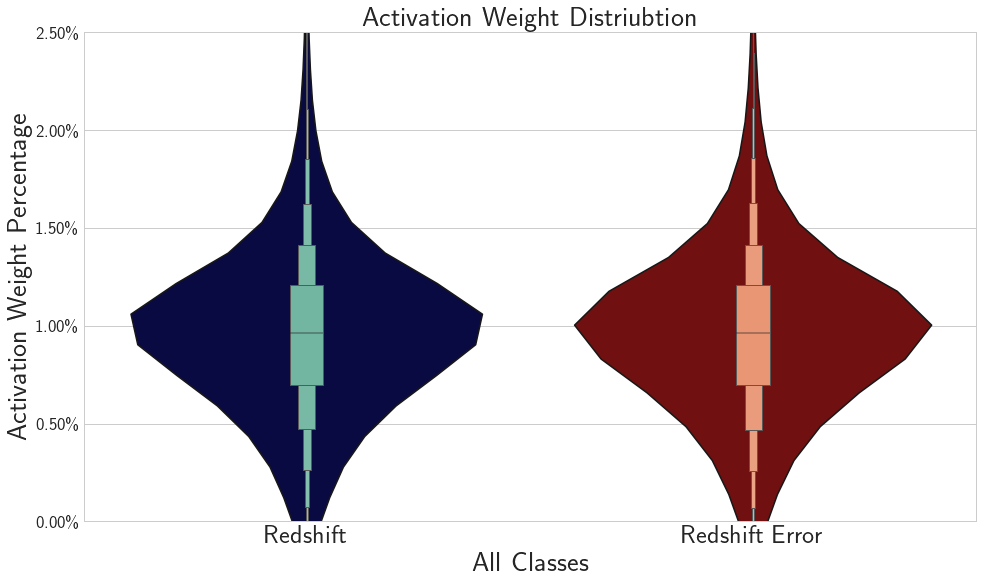

<Figure size 1152x648 with 0 Axes>

In [27]:
make_violin(dfza)

In [48]:
def show_cam(image_index, desired_class, counter):
    '''displays the class activation map of a particular image'''

  # takes the features of the chosen image
    features_for_img = features[image_index,:,:]

  # get the class with the highest output probability
    prediction = np.argmax(results[image_index])

  # get the gap weights at the predicted class
    class_activation_weights = gap_weights[:,prediction]

  # upsample the features to the image's original size (28 x 28)
#   class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)
    class_activation_features = features_for_img

  # compute the intensity of each feature in the CAM
    cam_output = np.dot(class_activation_features,class_activation_weights)
    print(cam_output.shape)
    print(np.expand_dims(cam_output, axis=0).shape)
    cam_output = np.expand_dims(cam_output, axis=0)
    print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[image_index][prediction]))

    from sklearn.preprocessing import minmax_scale, normalize
    cam_output = minmax_scale(cam_output, feature_range=(0,1), axis=1)
    cam_output = normalize(cam_output, norm='l1')

#     cam_output_softmax = softmax(cam_output)
    # cam_output_softmax = cam_output

    print(cam_output.sum(axis=1))
    cam_output_L = cam_output[:,:100]
    cam_output_z = cam_output[:,100:102]
    print(cam_output_L.shape, cam_output_z.shape)

    if (results[image_index][prediction] < 0.993):
        return False

    dfz = pd.DataFrame(data=cam_output_z, columns=["redshift", "redshift-error"])

    my_cmap = sns.light_palette("Navy", as_cmap=True)
    mpl.style.use("seaborn-whitegrid")
    fig, axs = plt.subplots(1, 2, figsize=(26, 8), gridspec_kw={'width_ratios': [3, 1]})
#     fig, ax = plt.subplots(figsize=(20, 8))

    dfz.plot(kind="bar", ax=axs[1], width=0.1, color=plt.cm.seismic(np.linspace(0, 1, 2)))
    axs[1].yaxis.set_label_position("right")
    axs[1].yaxis.set_tick_params(labelsize=22)
    axs[1].yaxis.tick_right()
    axs[1].set_xlabel(r'Additional Features, $R$', fontsize=28)
    axs[1].set_ylabel(r'Activation Weight Percentage', fontsize=28)
    axs[1].set_xticklabels([])
    axs[1].legend(["Redshift", "Redshift Error"], fontsize=18, loc='best')
    axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=cam_output.sum(), decimals=1))
#     axs[1].yaxis.set_minor_formatter(ticker.ScalarFormatter())
#     axs[1].ticklabel_format(style='sci', axis='y', scilimits=(-10,2))
    print(dfz.head())

    # Heatmap axis
    ax = axs[0]

    formatter = ticker.PercentFormatter(xmax=cam_output.sum(), decimals=None)
#     formatter.set_scientific(True)
#     formatter.set_powerlimits((-2, 2))
    sns.set(font_scale=2)
    hm = sns.heatmap(cam_output_L,
                        cmap=my_cmap,
                        cbar=True,
                        robust=False,
                        ax=ax,
                        annot=False,
                        cbar_kws={"format": formatter},
                        vmax=cam_output.max(),
                        vmin=cam_output.min(), 
                    )

    print("MAX L:", cam_output_L.max(), np.argmax(cam_output_L))
    print("SUM L:", cam_output_L.sum())
    print("SUM z:", cam_output_z.sum())
    print("SUM CAM:", cam_output.sum())
    print("MIN CAM:", cam_output.min())
#     hm.collections[0].colorbar.set_label(r'Attention Weight Percentage', fontsize=28)
#     cb.ax.yaxis.set_major_formatter(plt.FuncFormatter(myfmt))
#     hm.collections[0].colorbar.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=1))
#     hm.collections[0].colorbar.set_ticks([0, .25, 0.50, .75, 1])
#     hm.collections[0].colorbar.set_ticklabels([r'0\%', r'25\%', r'50\%', r'75\%', r'100\%'])

    ax2 = ax.twinx()

    lc = ax2.plot(X_test[image_index], lw=5)
    ax2.legend(lc, [r'$g$', r'$i$', r'$r$', r'$u$', r'$y$', r'$z$'], loc="center left", markerfirst=False, bbox_to_anchor=(-0.15, 0.75), fontsize=26)

    ax2.grid(False)
    ax2.set_yticklabels([])
    ax2.get_yaxis().set_visible(True)
    ax2.yaxis.set_ticks_position('none') 

    ax.set_xlabel(r'Time Sequence Index, $l$', fontsize=28)
#     ax.set_xlabel(r'Sequence Length, $L$', fontsize=28)
#     ax.set_title(r'')

    ax2.set_ylabel(r'Activation Weight Percentage', fontsize=28)

    ax.tick_params(which='minor', width=1.25)
    ax.tick_params(which='minor', length=3.5)
    ax.xaxis.set_tick_params(labelsize=26)

    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter(r'${%d}$'))

    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.get_yaxis().set_visible(False)
    ax.set_yticklabels([])

  # display the image
    fig.suptitle(rf"Predicted Class: {class_names[desired_class]} with Probability = {results[image_index][prediction]:.3f}", fontsize=36)
    fig.tight_layout()
    plt.savefig(
        f"{asnwd}/astronet/t2/plots/plasticc/cams/CAM-{class_names[desired_class]}-{counter:02d}-{image_index}.pdf",
        format="pdf",
        bbox_inches="tight",
    )
    plt.show()
    plt.clf()

In [49]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates CAMs
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class > (len(class_names) - 1):
        print("please choose a class between 0 and {len(class_names) - 1}")

    # go through the first 10000 images
    for i in range(0,50000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break
            
        # images that match the class will be shown
        random_sample = np.random.choice(len(results), 1)[0]
        if np.argmax(results[random_sample]) == desired_class:
            sc = show_cam(random_sample, desired_class, counter)
            if sc is not None:
                continue
            else:
                counter += 1

In [50]:
def make_cams(num_maps=40):

    for i in range(len(class_names)):
        show_maps(desired_class=i, num_maps=num_maps)

In [51]:
mpl.style.use("seaborn-whitegrid")

In [52]:
class_names

['$\\mu$-Lens-Single',
 'TDE',
 'EB',
 'SNII',
 'SNIax',
 'Mira',
 'SNIbc',
 'KN',
 'M-dwarf',
 'SNIa-91bg',
 'AGN',
 'SNIa',
 'RRL',
 'SLSN-I']

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9990102
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.003229058347642 0.003649211721495
MAX L: 0.021048939 64
SUM L: 0.9931217
SUM z: 0.00687827
SUM CAM: 1.0
MIN CAM: 0.0


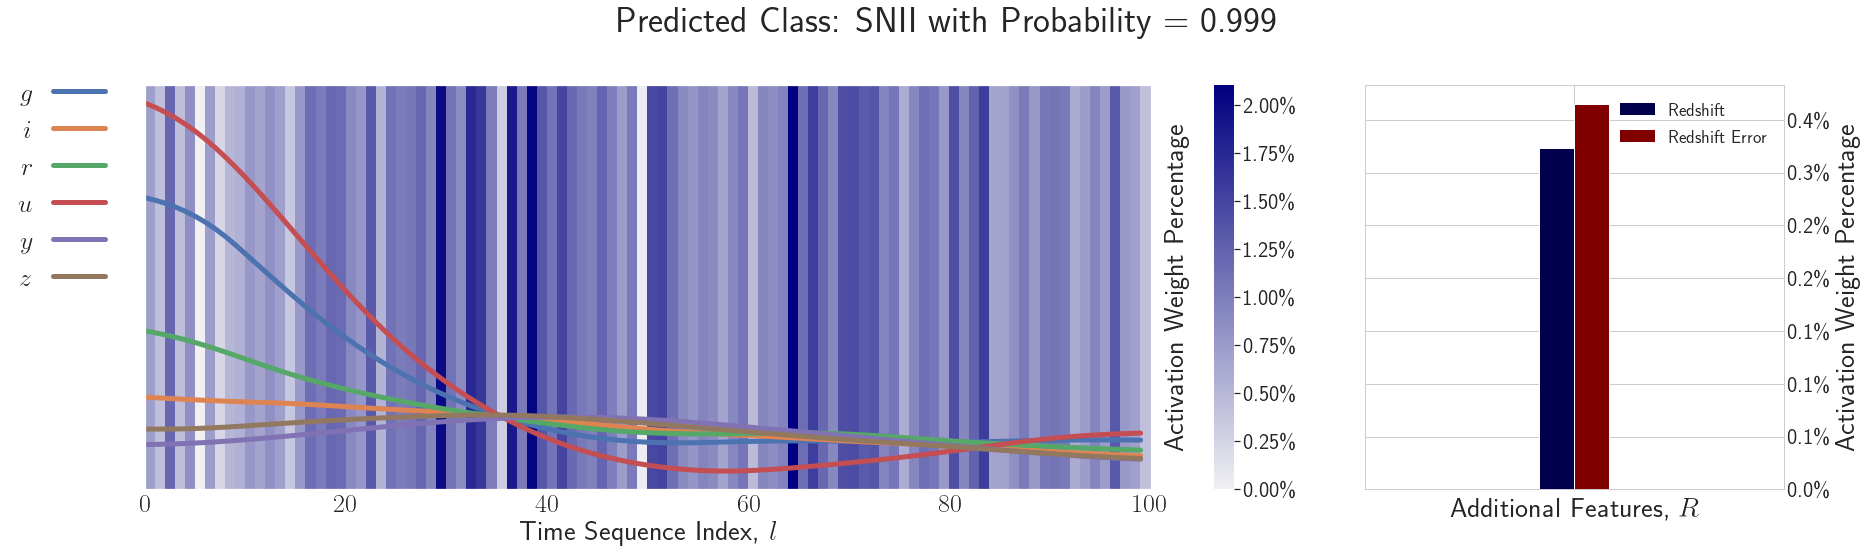

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.95355743
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.3634341
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9107789
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.5423162
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.30427533
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9917719
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.86346126
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.62918955
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.87577856
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9998634
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.006273703649640 0.001047803671099
MAX L: 0.017328419 62
SUM L: 0.99267846
SUM z: 0.007321507
SUM

<Figure size 1152x648 with 0 Axes>

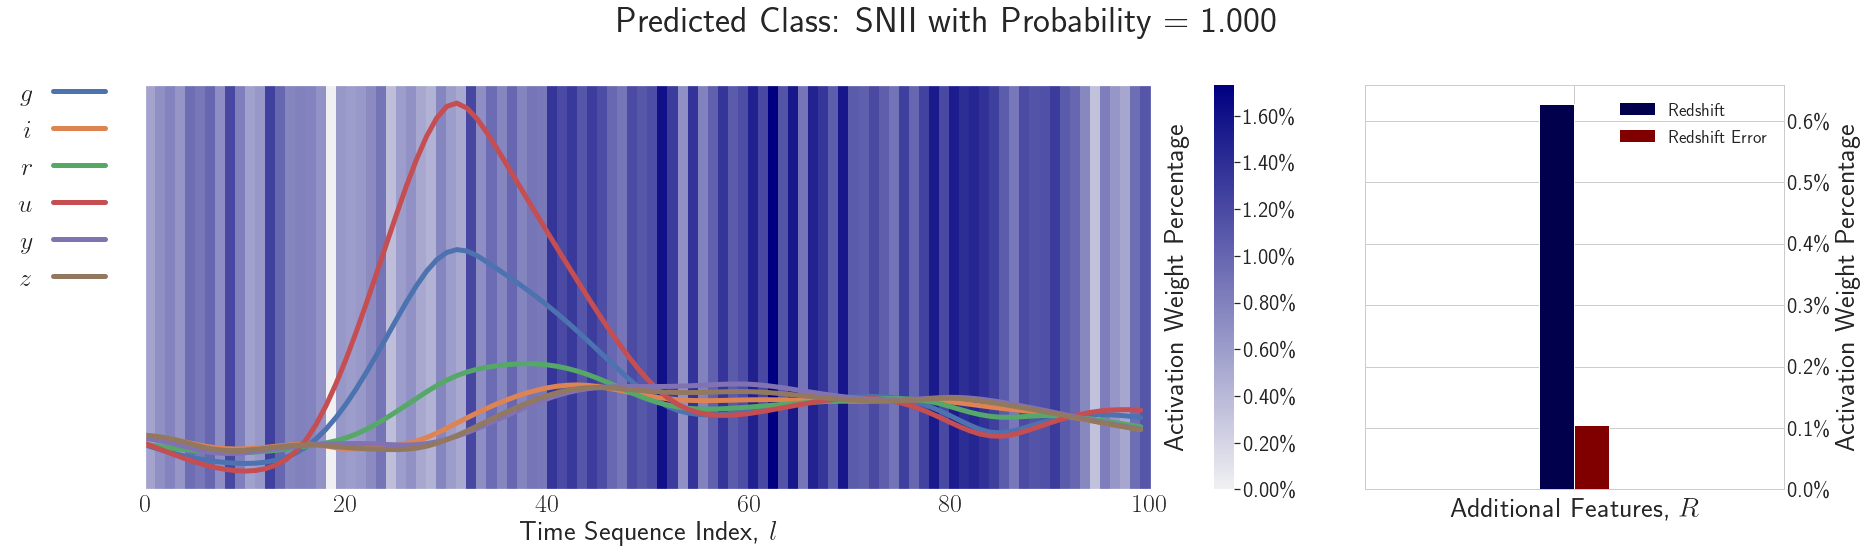

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.77398163
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.43159145
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.45057148
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9926265
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.48184162
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8355024
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.3193065
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8733134
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9935475
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.006691116373986 0.008536599576473
MAX L: 0.027117372 47
SUM L: 0.98477244
SUM z: 0.015227716
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

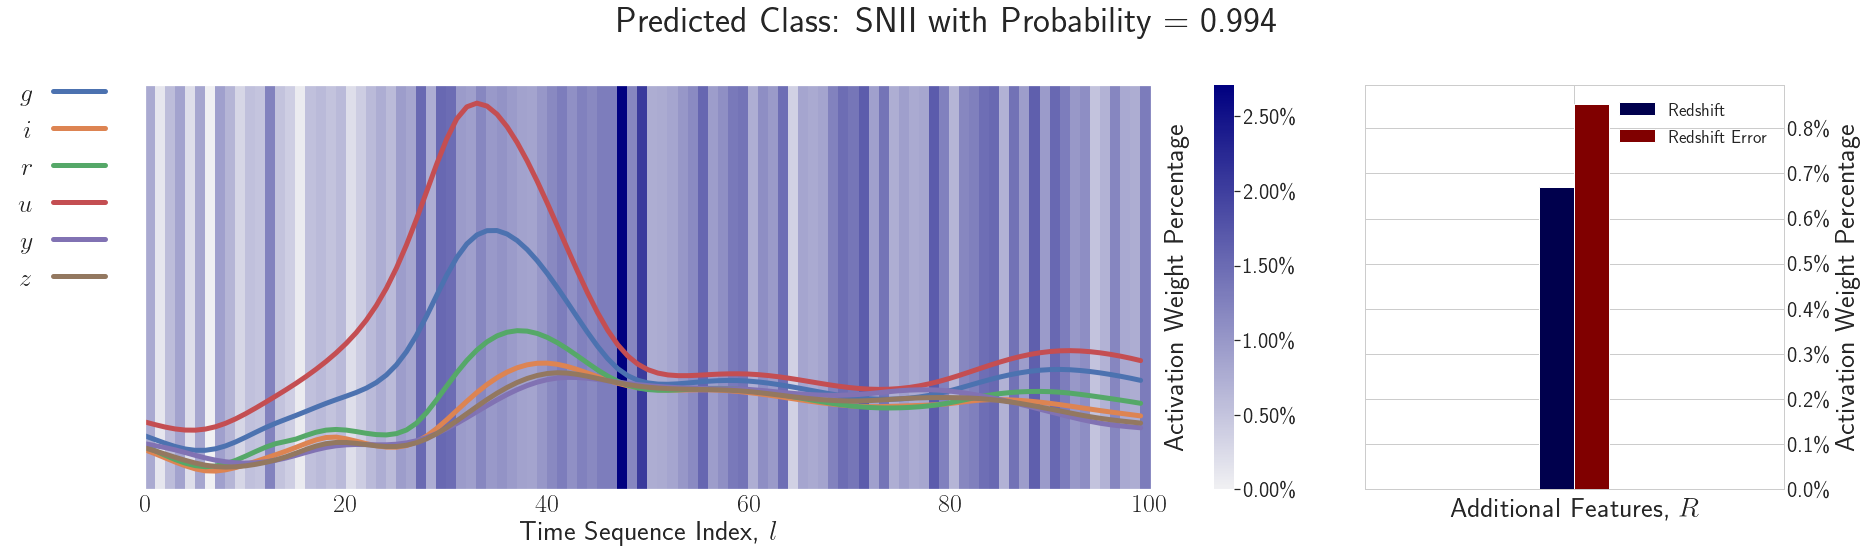

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.7129216
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9814268
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.41129062
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.95264286
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.97723675
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.97697794
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6157067
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.94332623
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.97072834
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.23671408
[1.0000002]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9733628
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.88

<Figure size 1152x648 with 0 Axes>

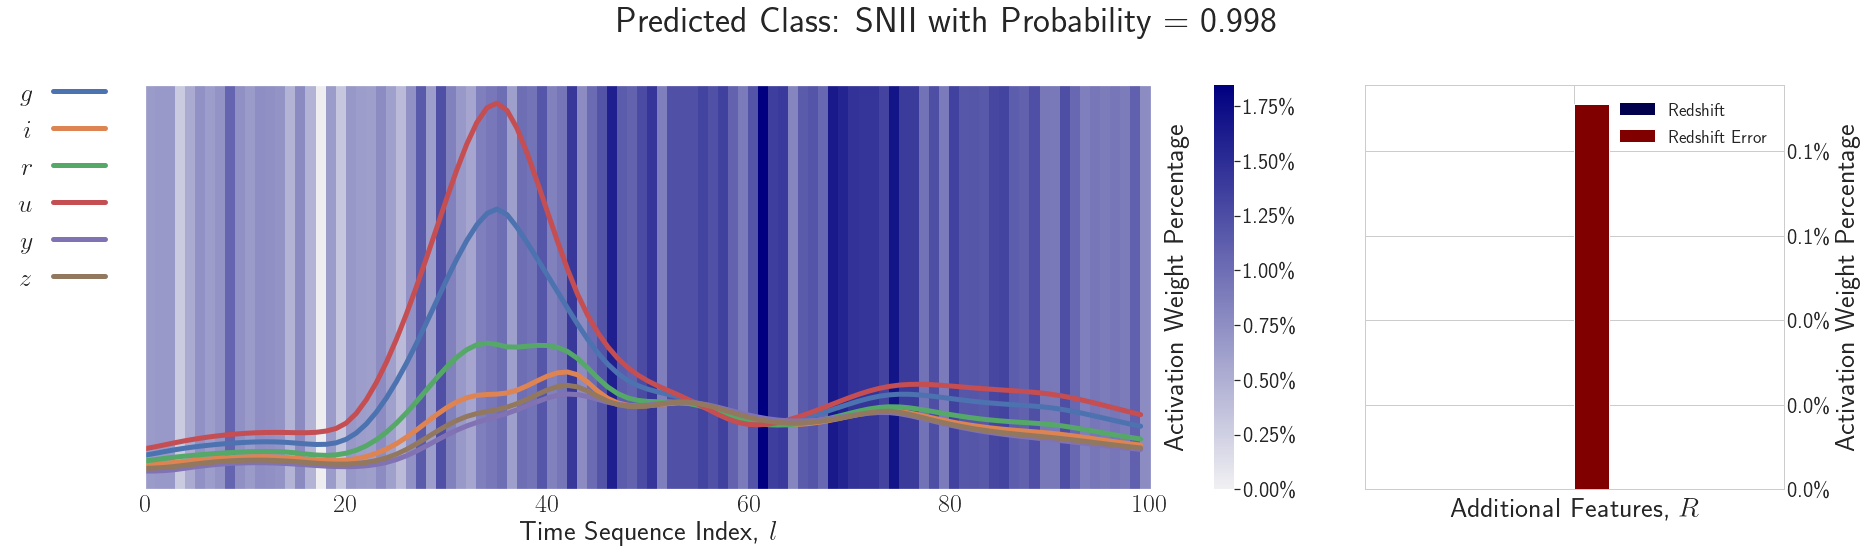

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.3053359
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9839871
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.92400223
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9886467
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8335021
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.70476615
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.54928386
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9136298
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6944848
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.4763996
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.606492
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3,

<Figure size 1152x648 with 0 Axes>

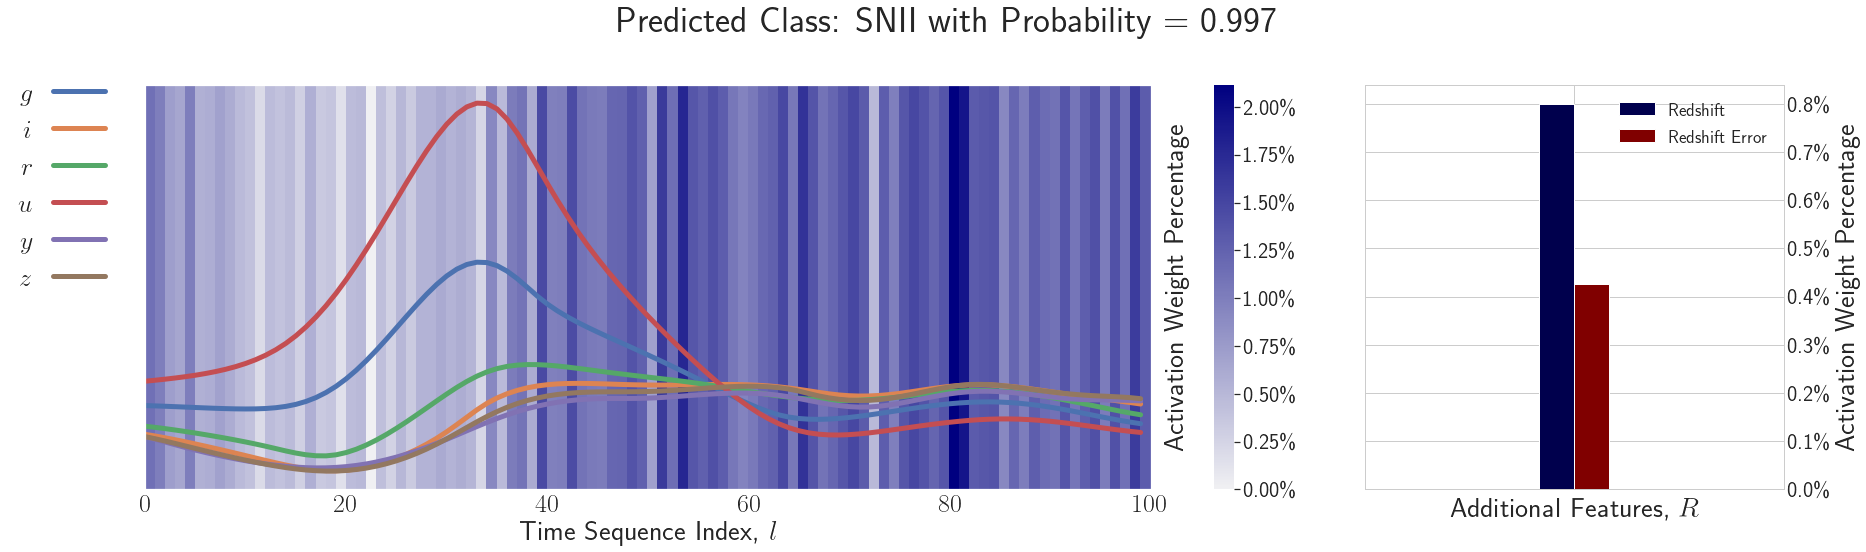

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8607564
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.45595792
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.5083403
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6009801
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.53287655
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.45857707
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9979513
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.010700561106205 0.009425040334463
MAX L: 0.02687674 76
SUM L: 0.9798743
SUM z: 0.020125601
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

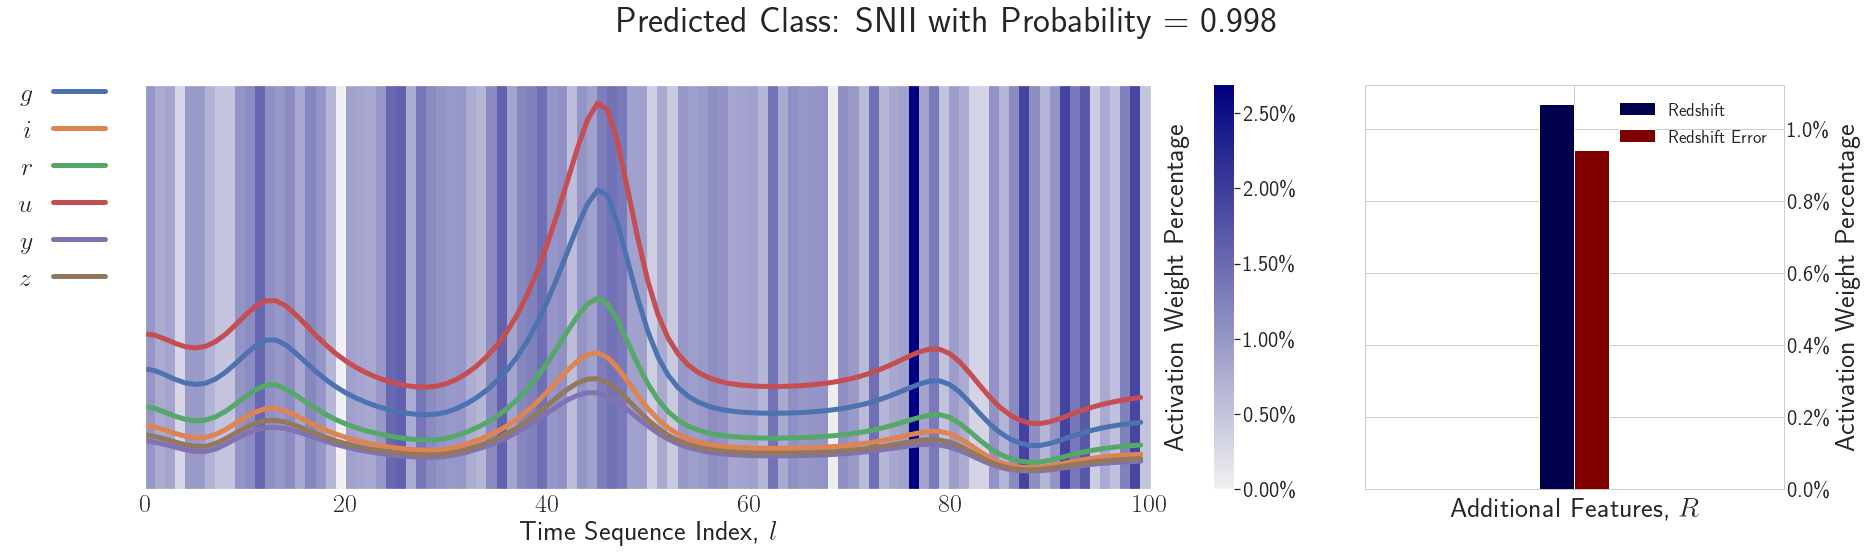

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.836843
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.55640703
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8862924
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8633958
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.45573616
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.96598357
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.36262664
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.4597084
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.62882555
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99100834
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.78004473
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Pr

<Figure size 1152x648 with 0 Axes>

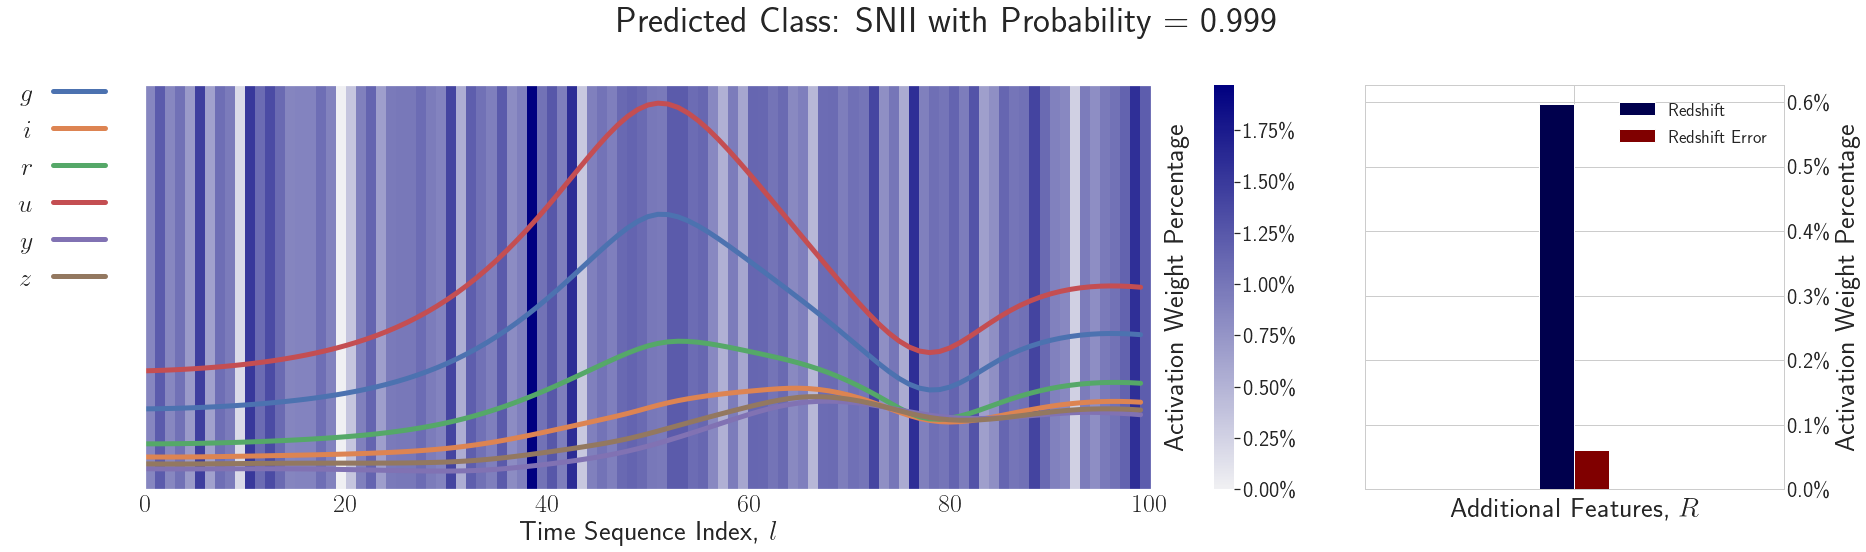

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.877581
[1.0000002]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6295911
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.80518323
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6637241
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.5963189
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99501294
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.005364638753235 0.006566734518856
MAX L: 0.017284451 75
SUM L: 0.9880687
SUM z: 0.011931373
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

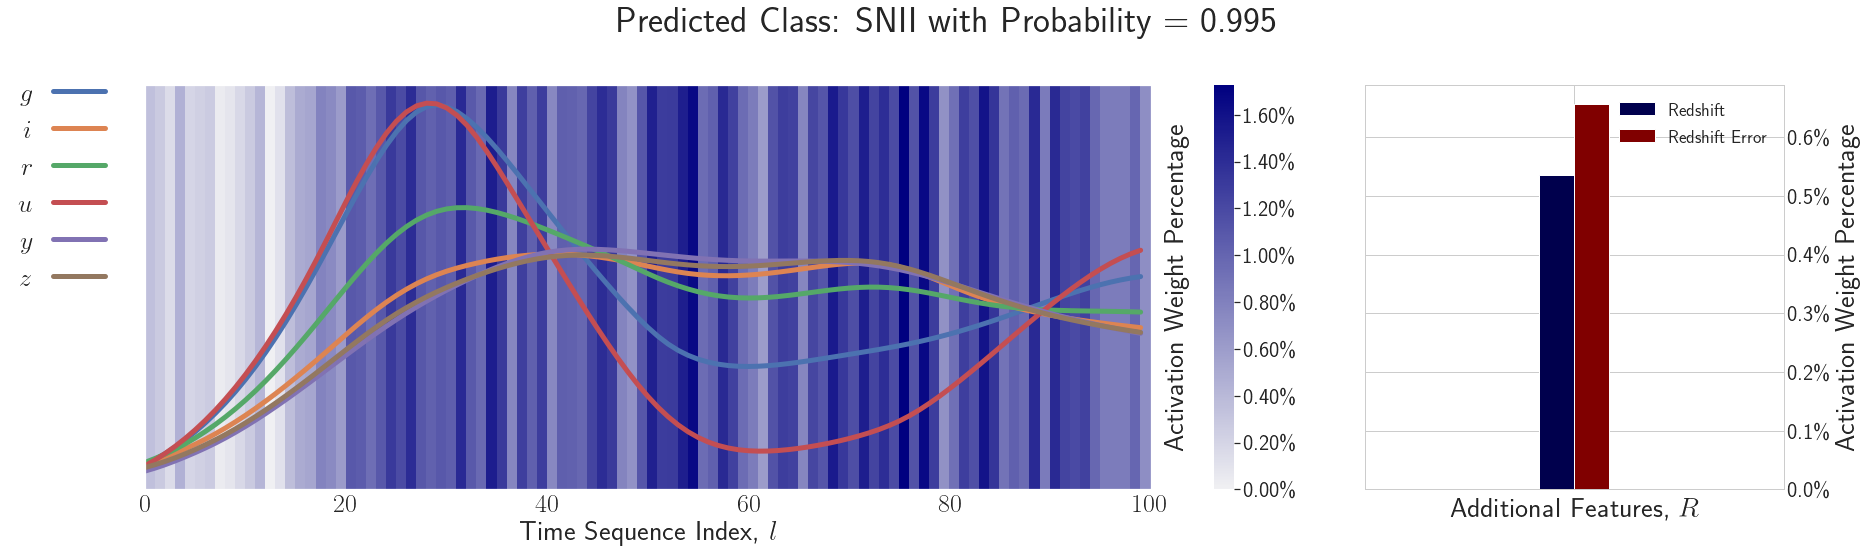

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.97726464
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.97077674
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6441517
[1.0000002]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.74287367
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9931584
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.001767987618223 0.003905114252120
MAX L: 0.018295316 59
SUM L: 0.99432683
SUM z: 0.005673102
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

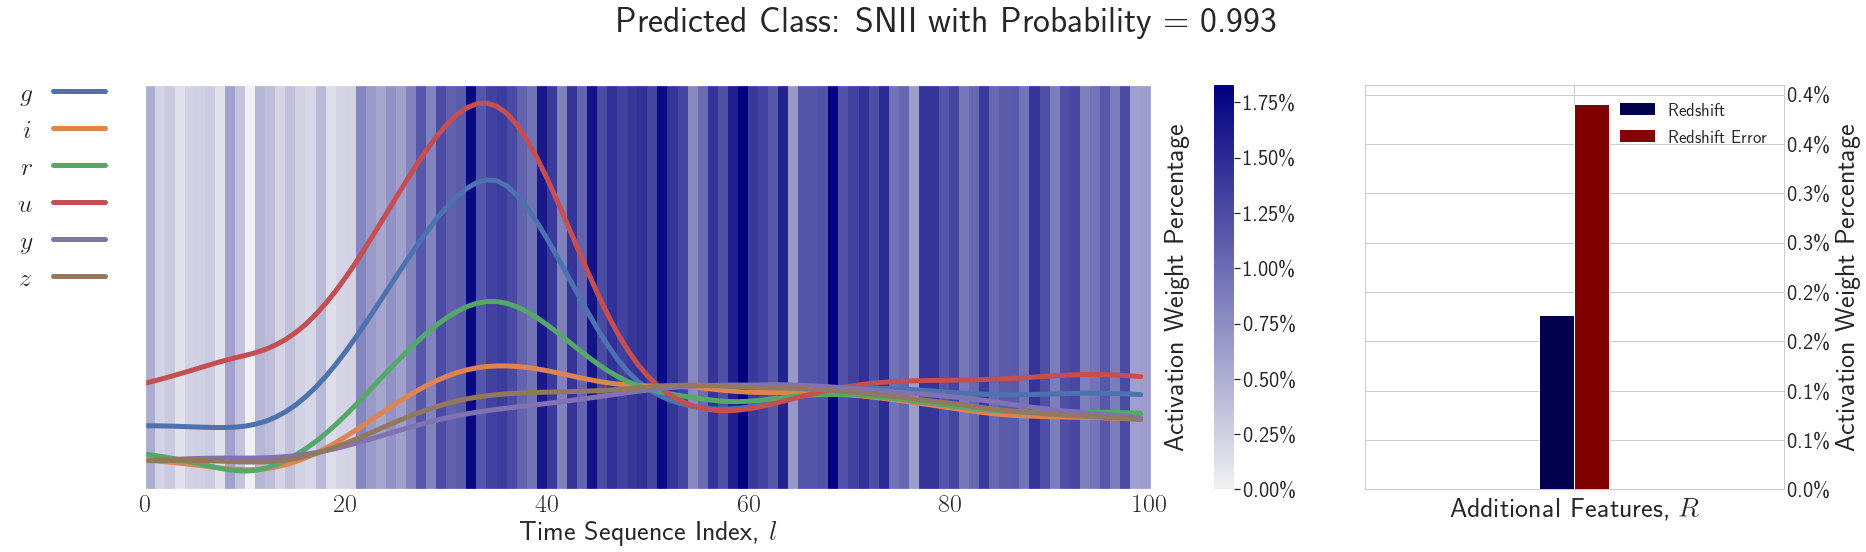

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.4706856
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.4028599
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9986318
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.003781981533393 0.005669154692441
MAX L: 0.01716527 93
SUM L: 0.99054885
SUM z: 0.009451136
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

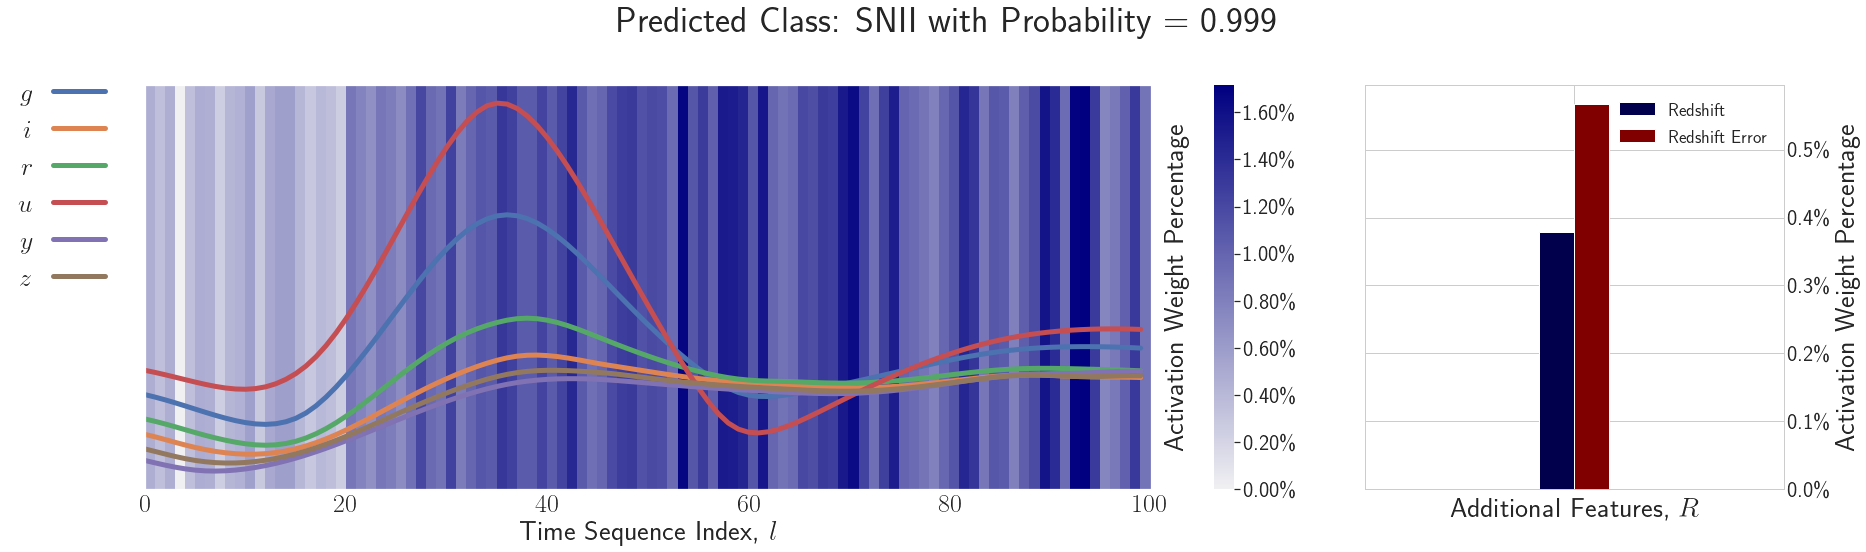

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.770957
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.80927217
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99795794
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.003191196592525 0.007341423537582
MAX L: 0.02651334 35
SUM L: 0.9894673
SUM z: 0.01053262
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

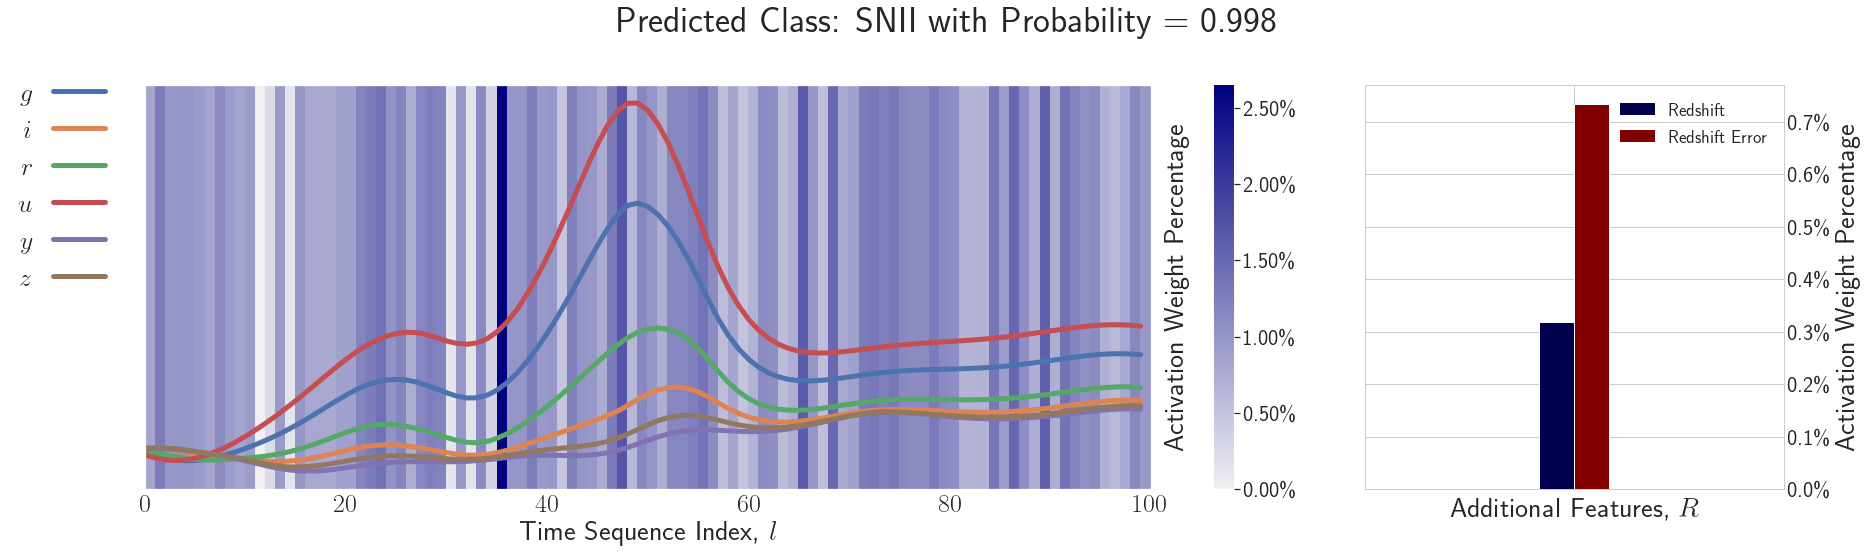

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.70706147
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.98178583
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.7925378
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9755347
[1.0000002]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.972626
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.3083797
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9797117
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9964755
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.000000000000000 0.000084366256488
MAX L: 0.02320129 54
SUM L: 0.9999157
SUM z: 8.436626e-05
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

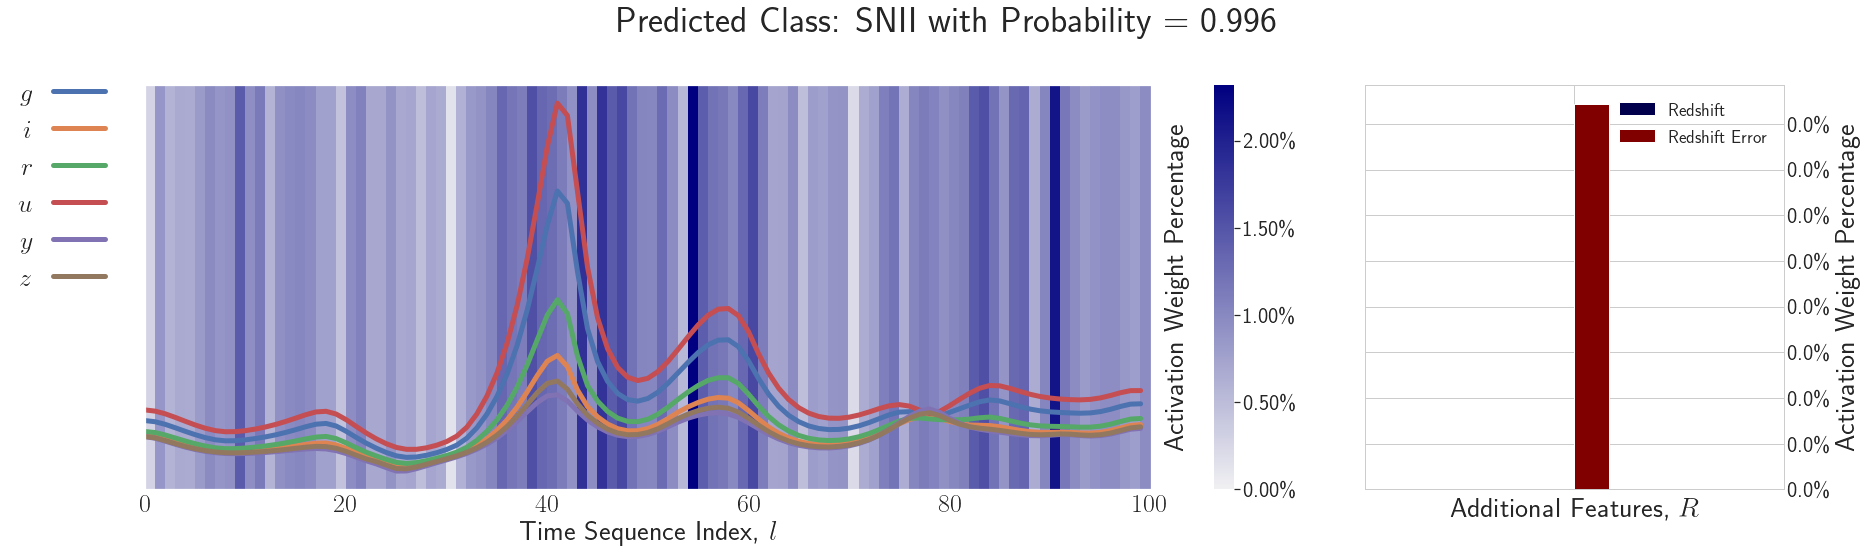

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.42218632
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.47815156
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.5548049
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9581999
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.67369807
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99629587
[0.9999998]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.001661024871282 0.001849798136391
MAX L: 0.021258986 58
SUM L: 0.99648905
SUM z: 0.003510823
SUM CAM: 0.9999998
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

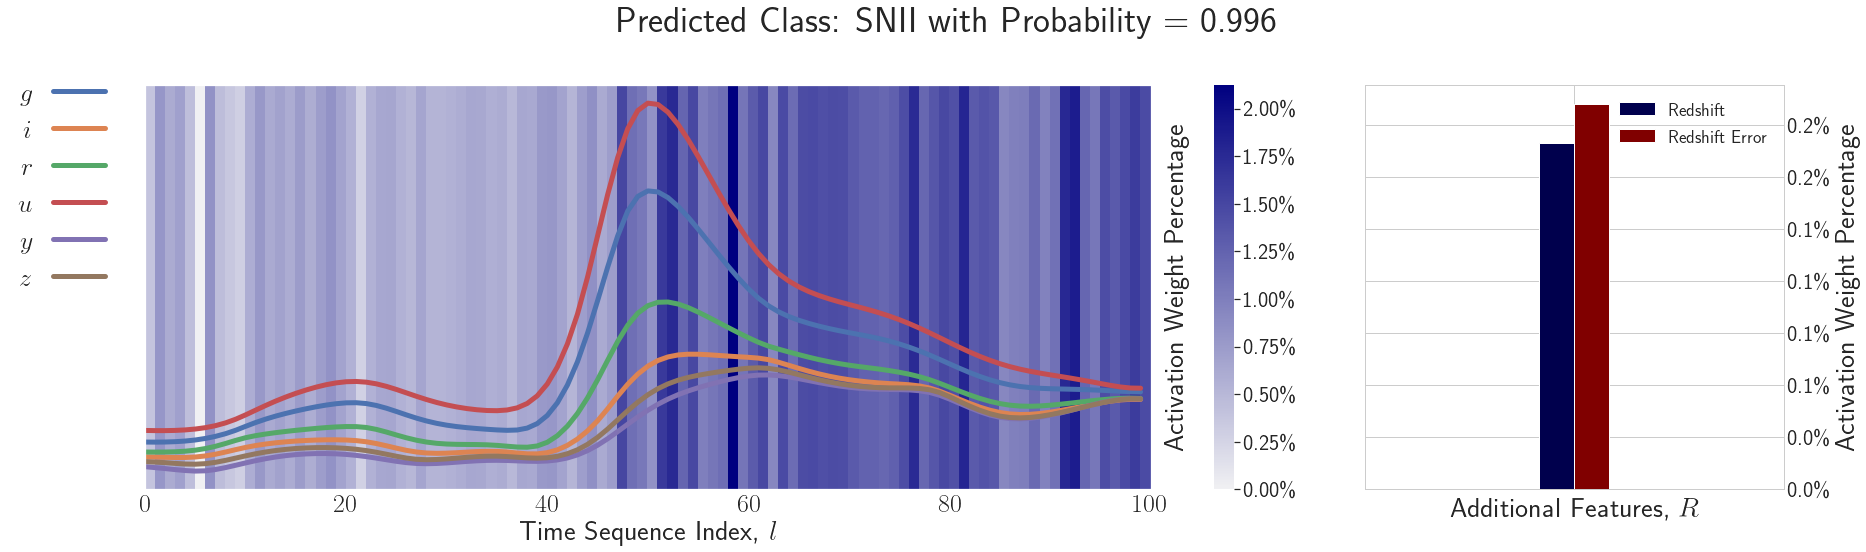

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9202331
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8437857
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.996064
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.000198072782950 0.003764056134969
MAX L: 0.018369308 42
SUM L: 0.99603784
SUM z: 0.003962129
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

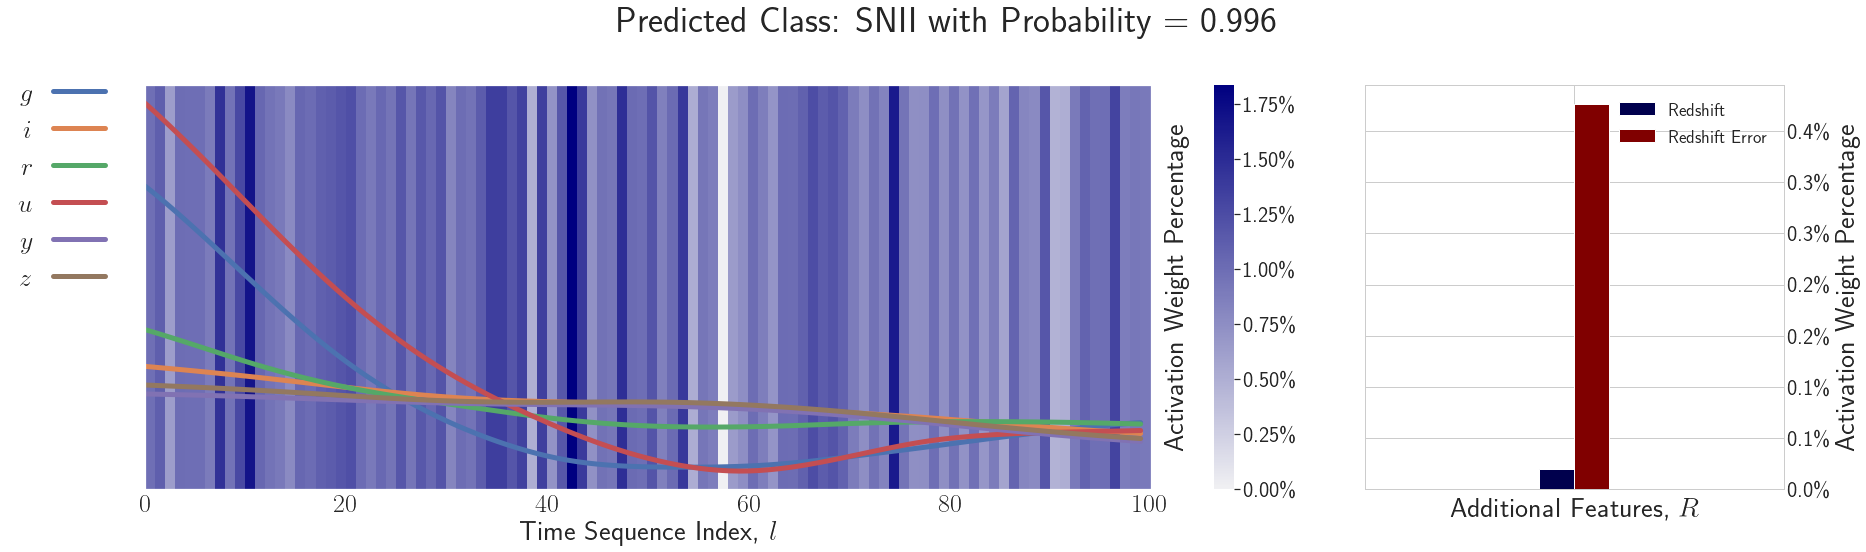

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9864334
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9967931
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.012712451629341 0.010867822915316
MAX L: 0.020196786 90
SUM L: 0.97641975
SUM z: 0.023580275
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

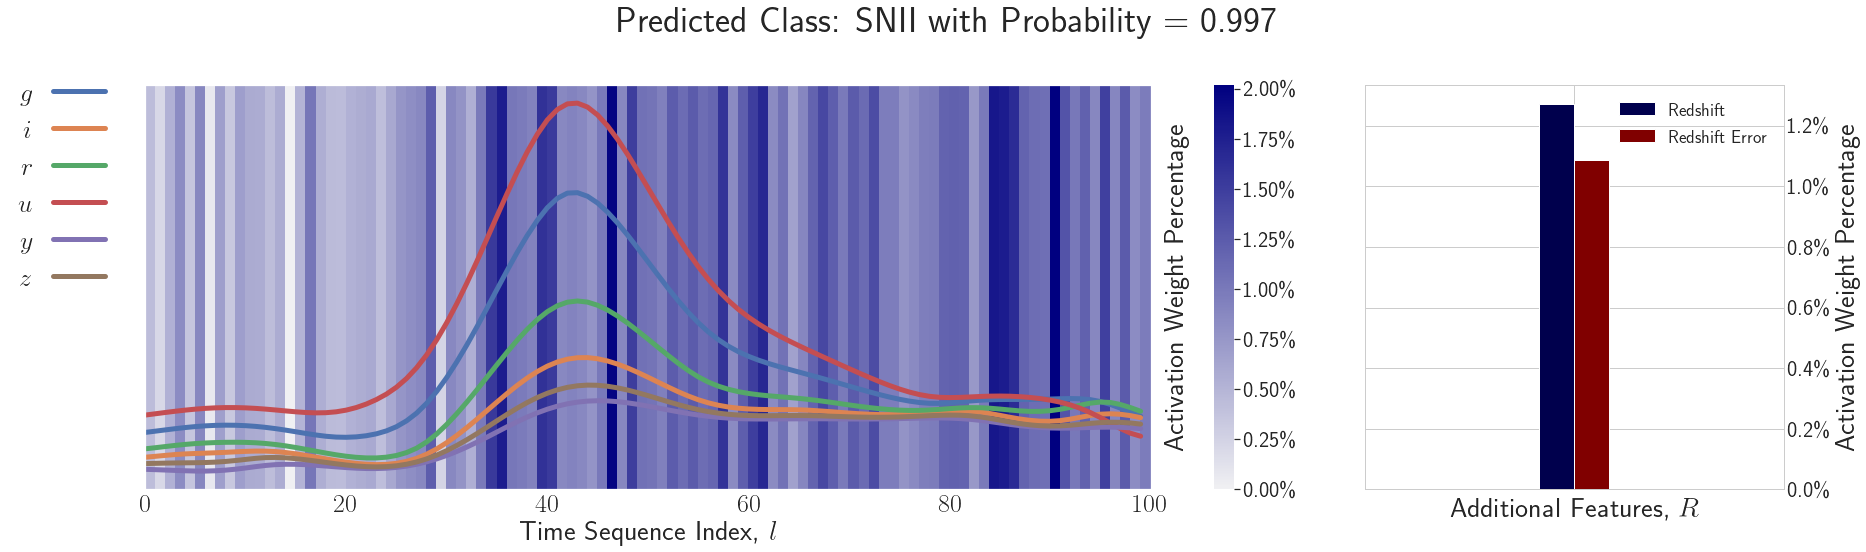

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8837135
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.90489095
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.79393977
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9660661
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.96366185
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.53847355
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.31551
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.80375385
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.94234085
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.7051227
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.63223594
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.98788

<Figure size 1152x648 with 0 Axes>

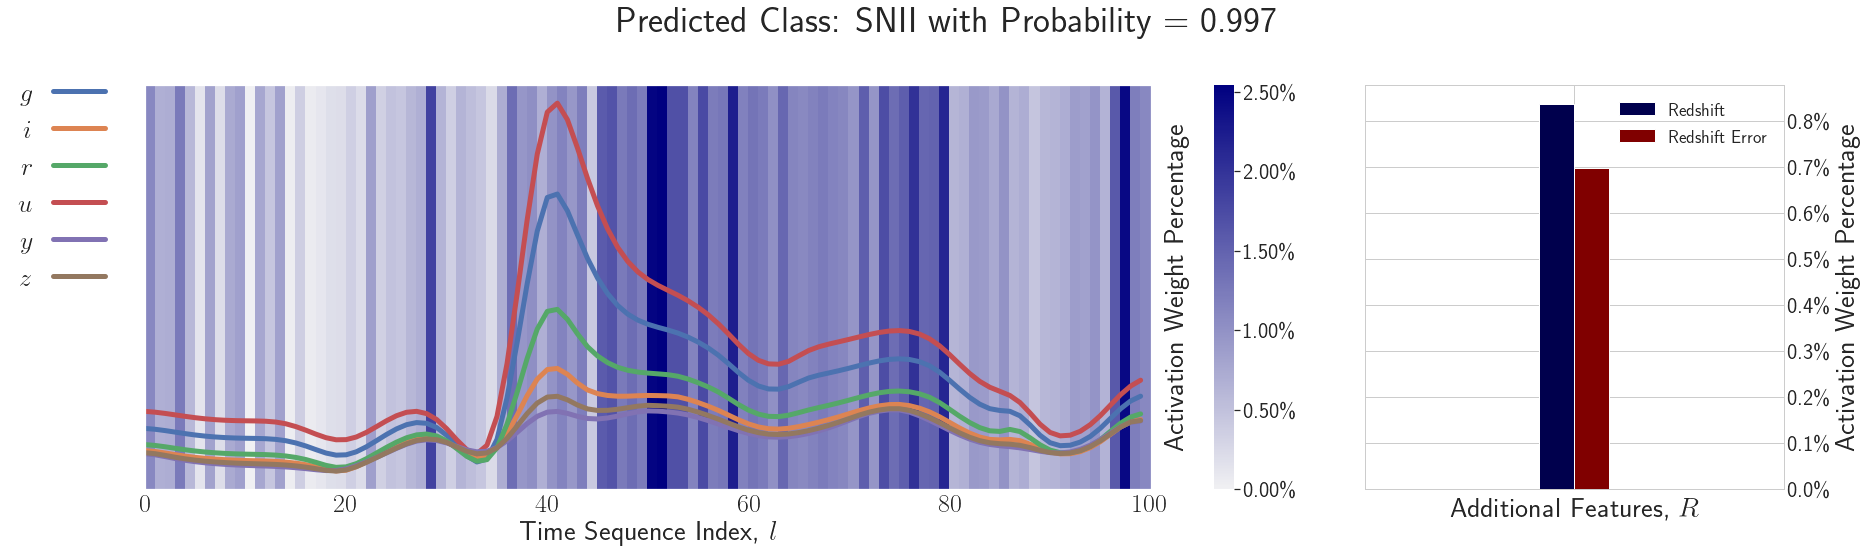

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9923672
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9911308
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.31304398
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9645523
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.825599
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9198265
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.998792
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.014057154767215 0.012967320159078
MAX L: 0.015967416 62
SUM L: 0.97297555
SUM z: 0.027024474
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

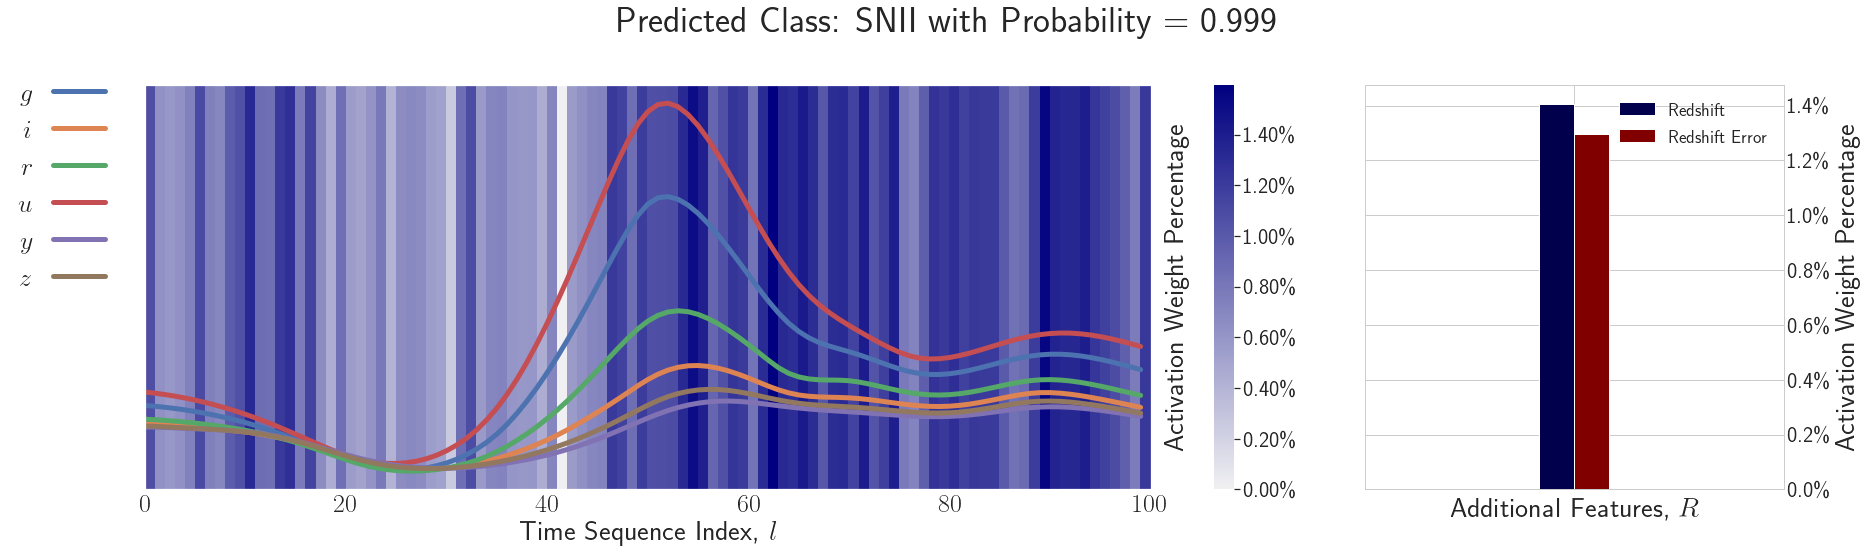

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9988489
[0.9999998]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.011447983793914 0.014634432271123
MAX L: 0.018371303 8
SUM L: 0.9739174
SUM z: 0.026082415
SUM CAM: 0.9999998
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

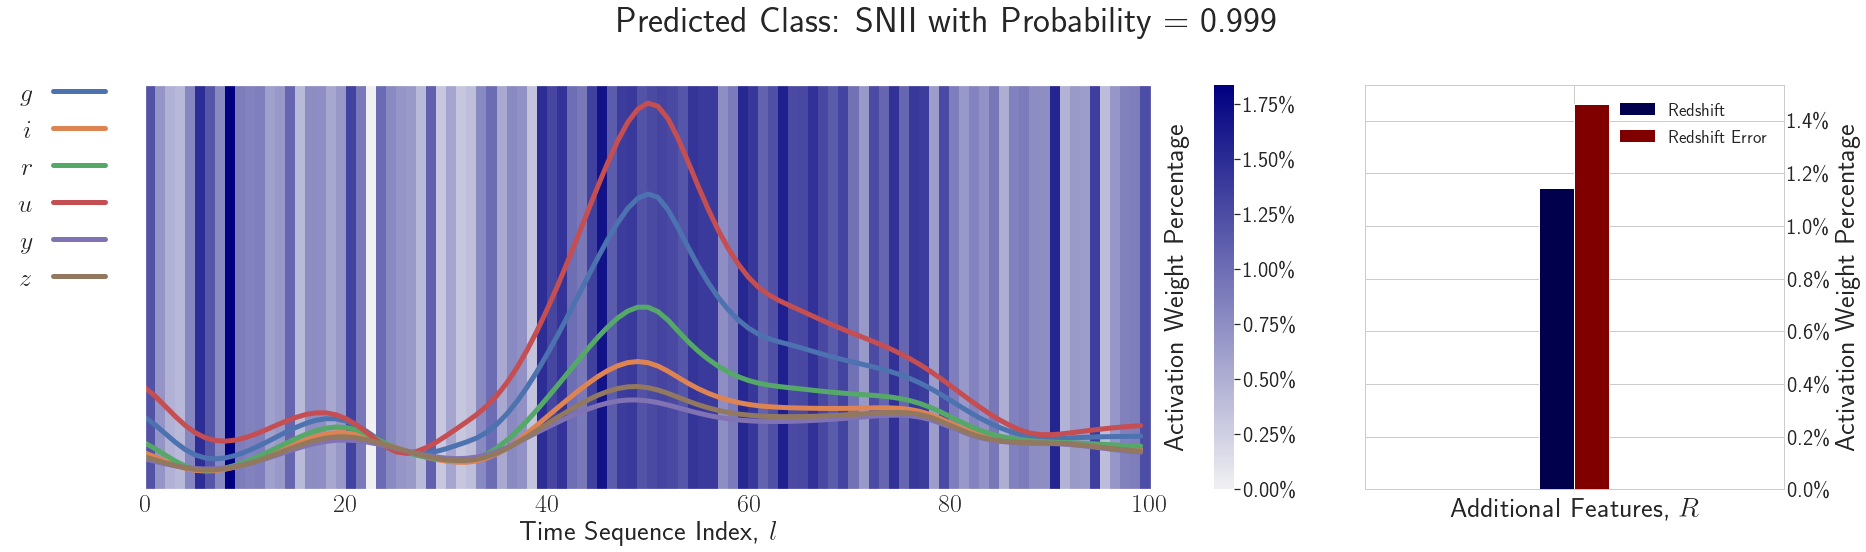

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9989998
[0.9999998]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.009463880211115 0.010403539985418
MAX L: 0.026093168 60
SUM L: 0.9801324
SUM z: 0.01986742
SUM CAM: 0.9999998
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

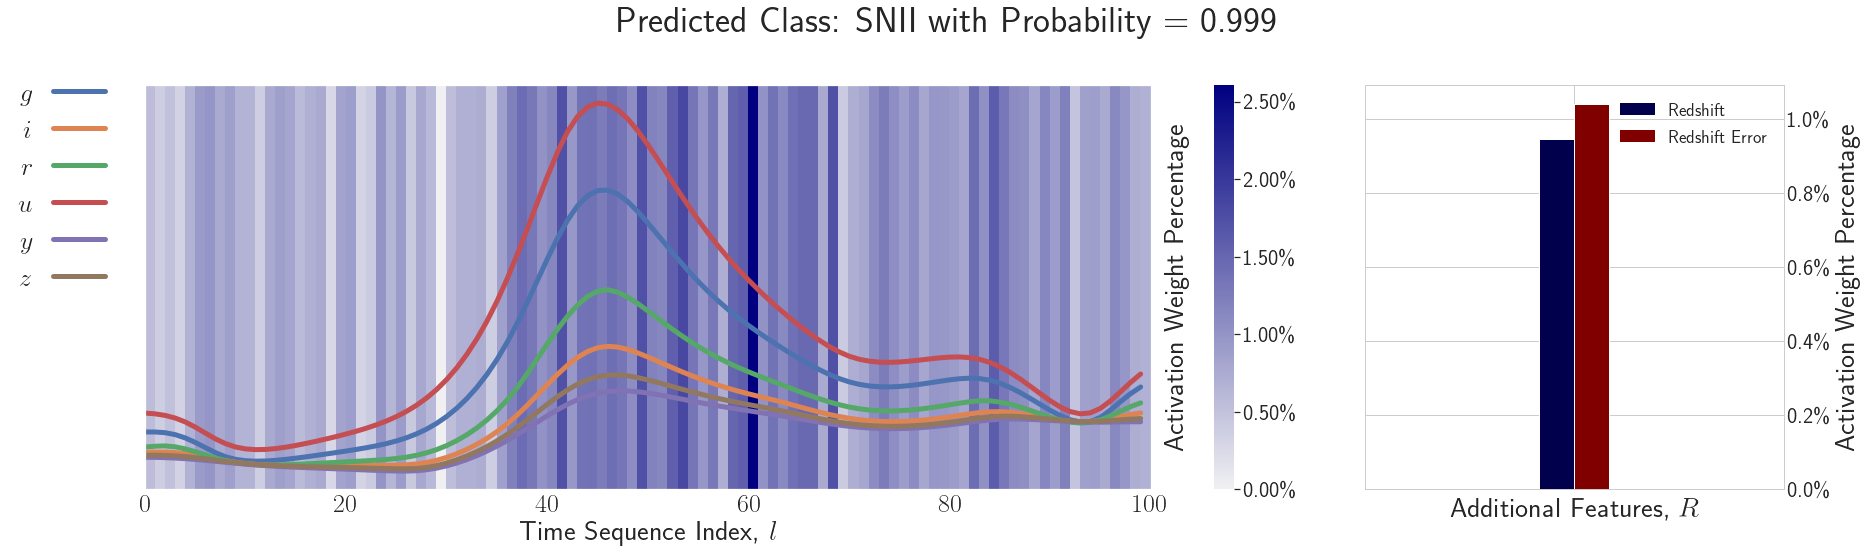

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9957558
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.000383279693779 0.012186677195132
MAX L: 0.023793695 67
SUM L: 0.98743004
SUM z: 0.0125699565
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

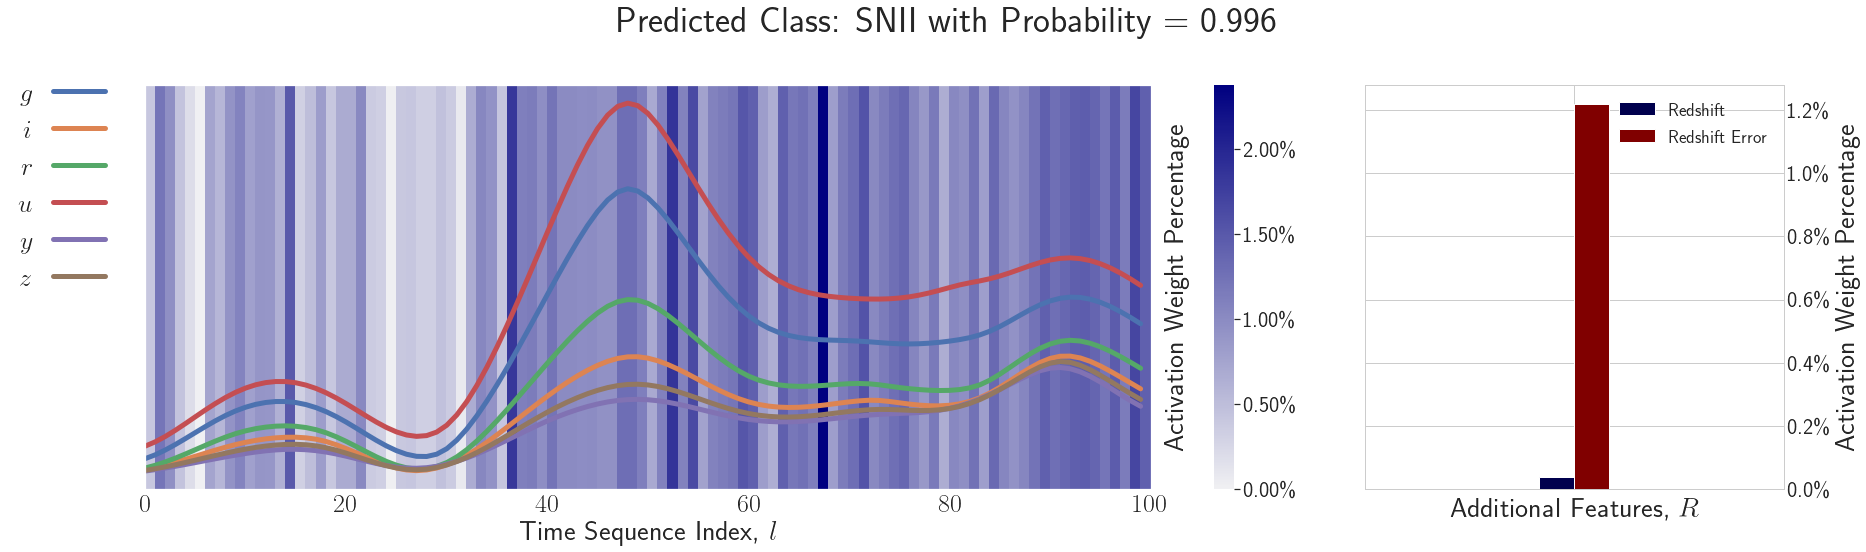

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.30880952
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9908313
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.7601799
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.70165646
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9367542
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.68015116
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.32906392
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.89883965
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9681078
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.7010404
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.45407087
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probabili

<Figure size 1152x648 with 0 Axes>

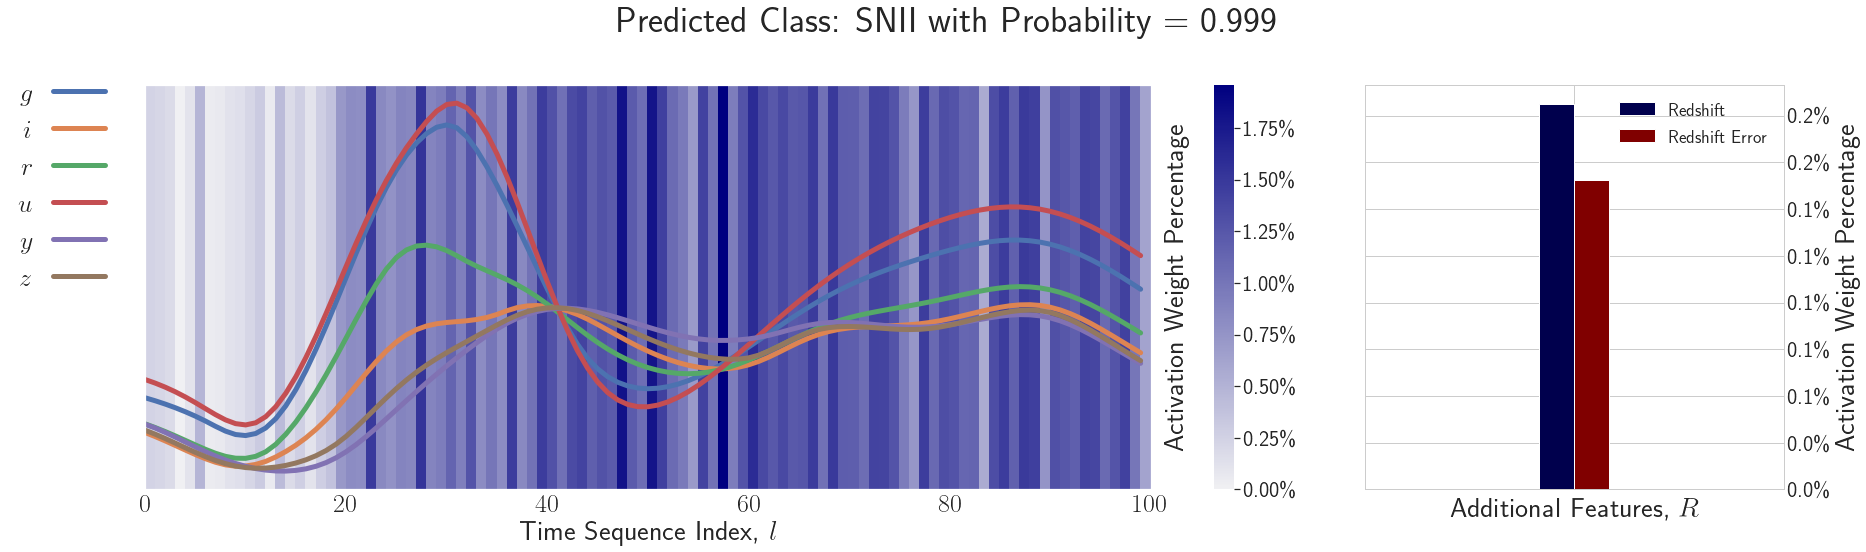

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9287737
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99537945
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.007027401588857 0.006791969761252
MAX L: 0.024459336 59
SUM L: 0.9861807
SUM z: 0.013819371
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

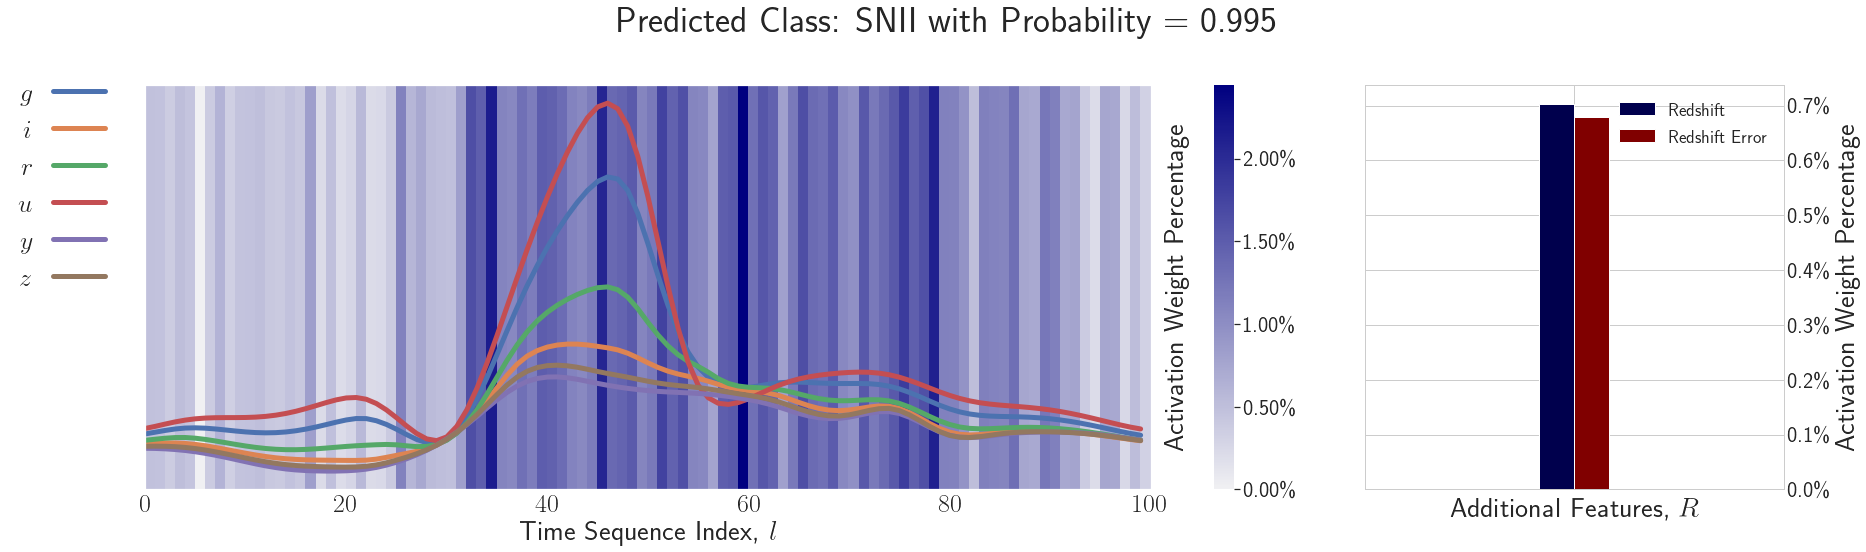

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.61808336
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99900097
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.010064609348774 0.013873721472919
MAX L: 0.021732641 55
SUM L: 0.97606176
SUM z: 0.023938332
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

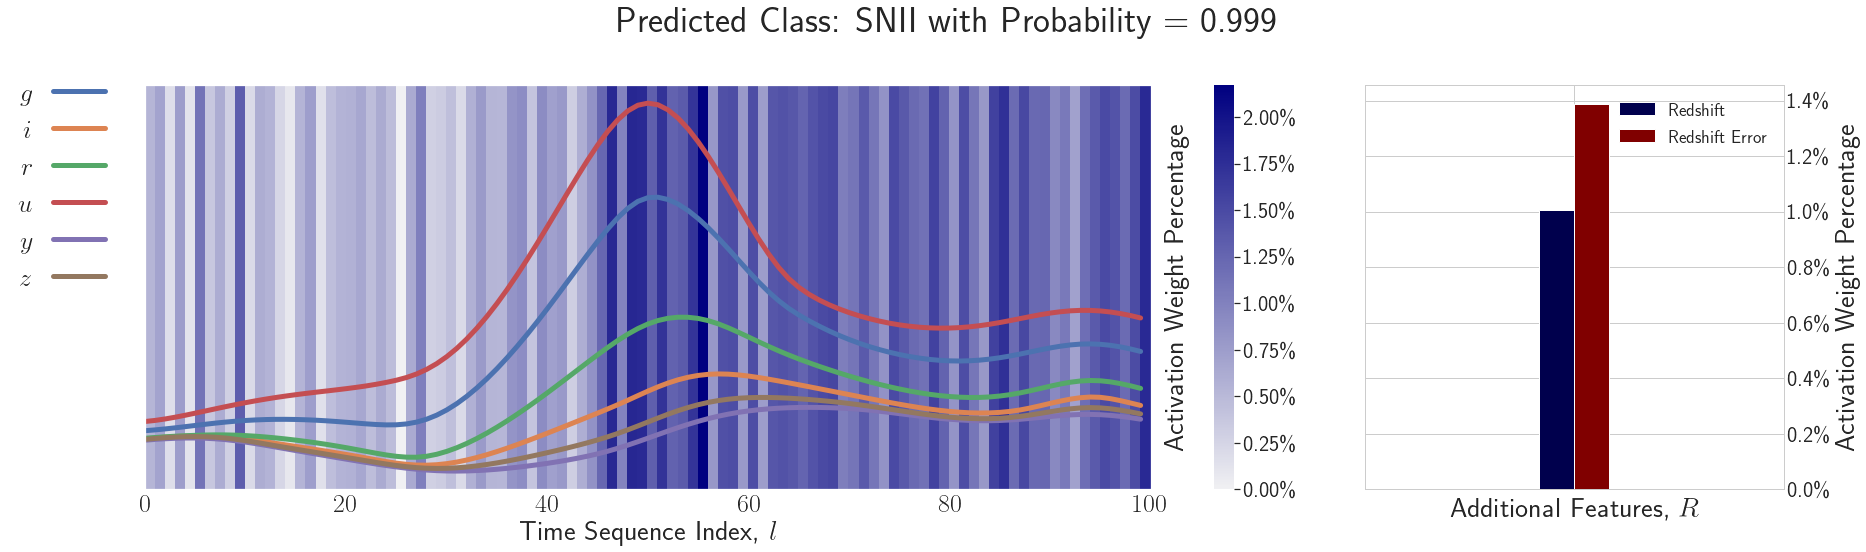

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.95595026
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.64192766
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.5010543
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6444717
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99889237
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.000000000000000 0.001102331443690
MAX L: 0.016725255 34
SUM L: 0.99889773
SUM z: 0.0011023314
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

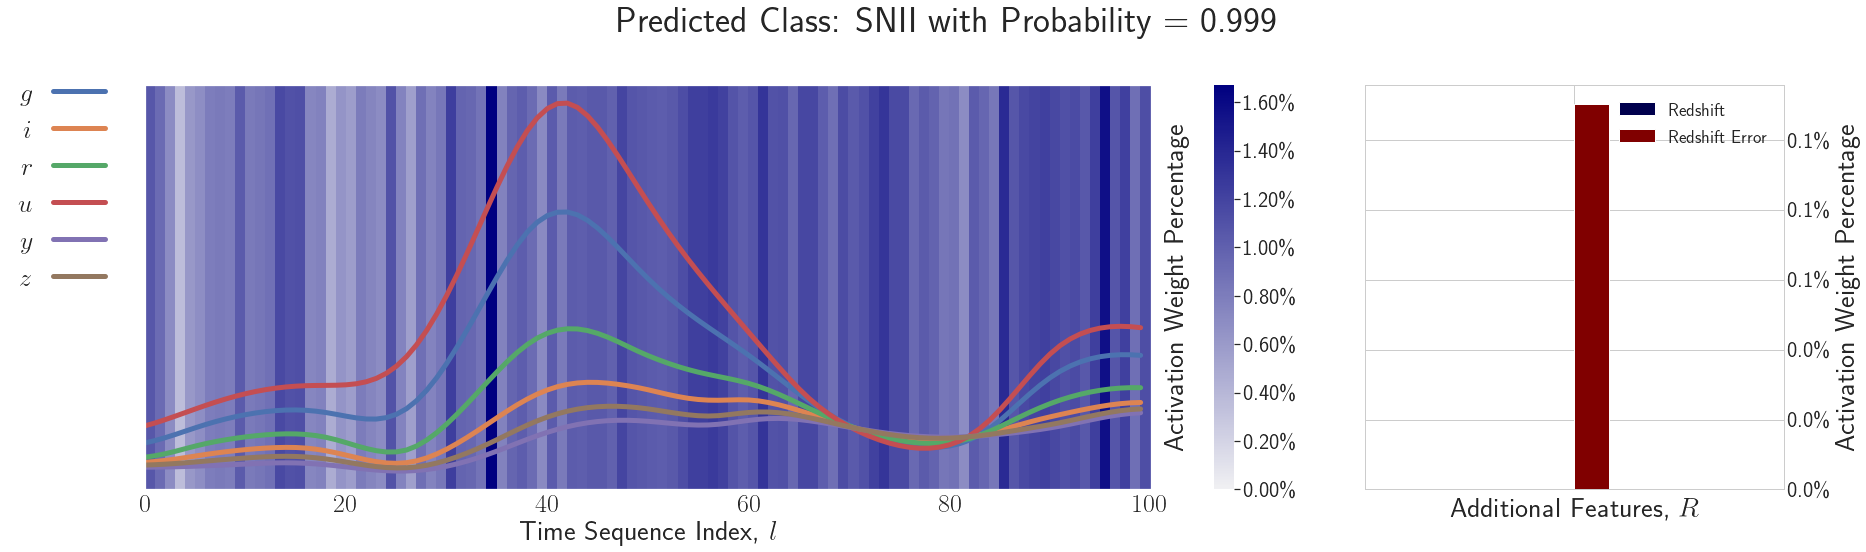

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.80880576
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.98061806
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.90896875
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8502487
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.61183757
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9891165
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9336313
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.64382404
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.7882507
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.4077663
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.61928415
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability

<Figure size 1152x648 with 0 Axes>

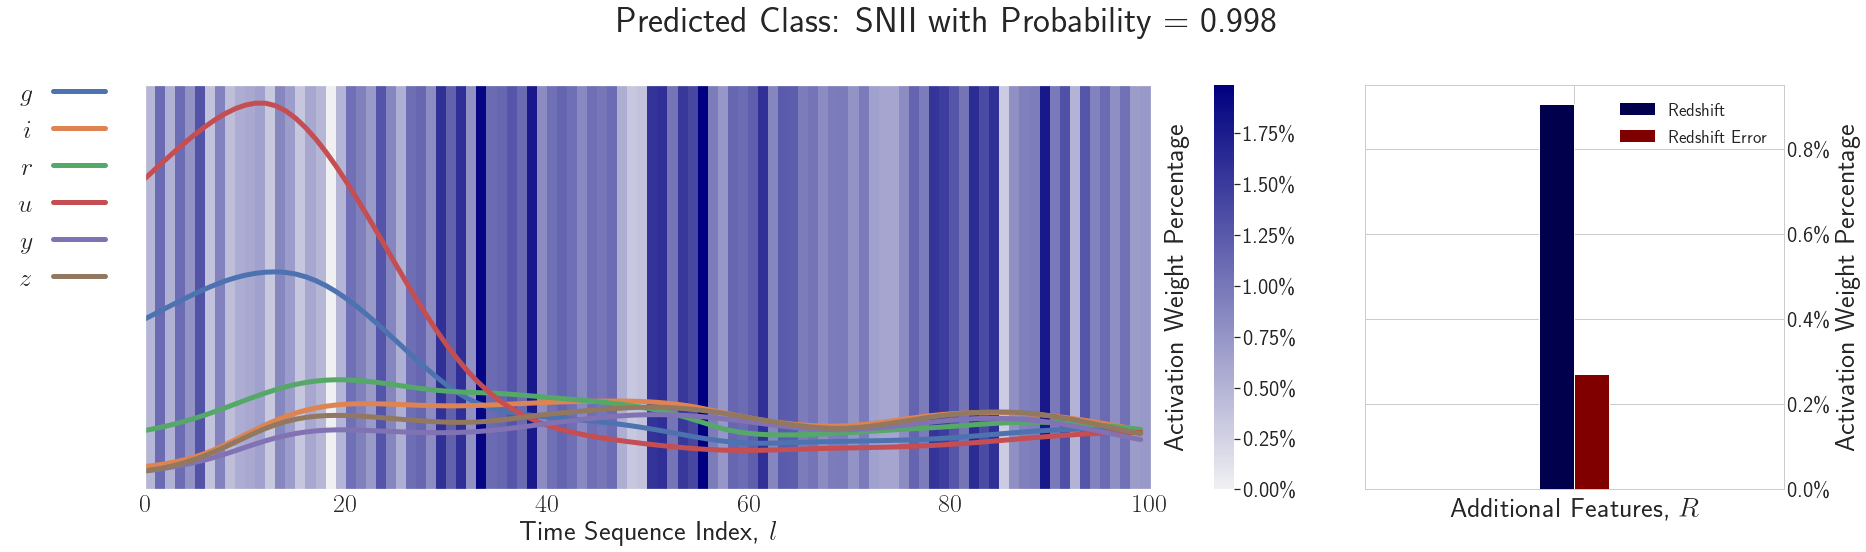

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.62531435
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99407756
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.000496918684803 0.000000000000000
MAX L: 0.023022303 7
SUM L: 0.9995032
SUM z: 0.0004969187
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

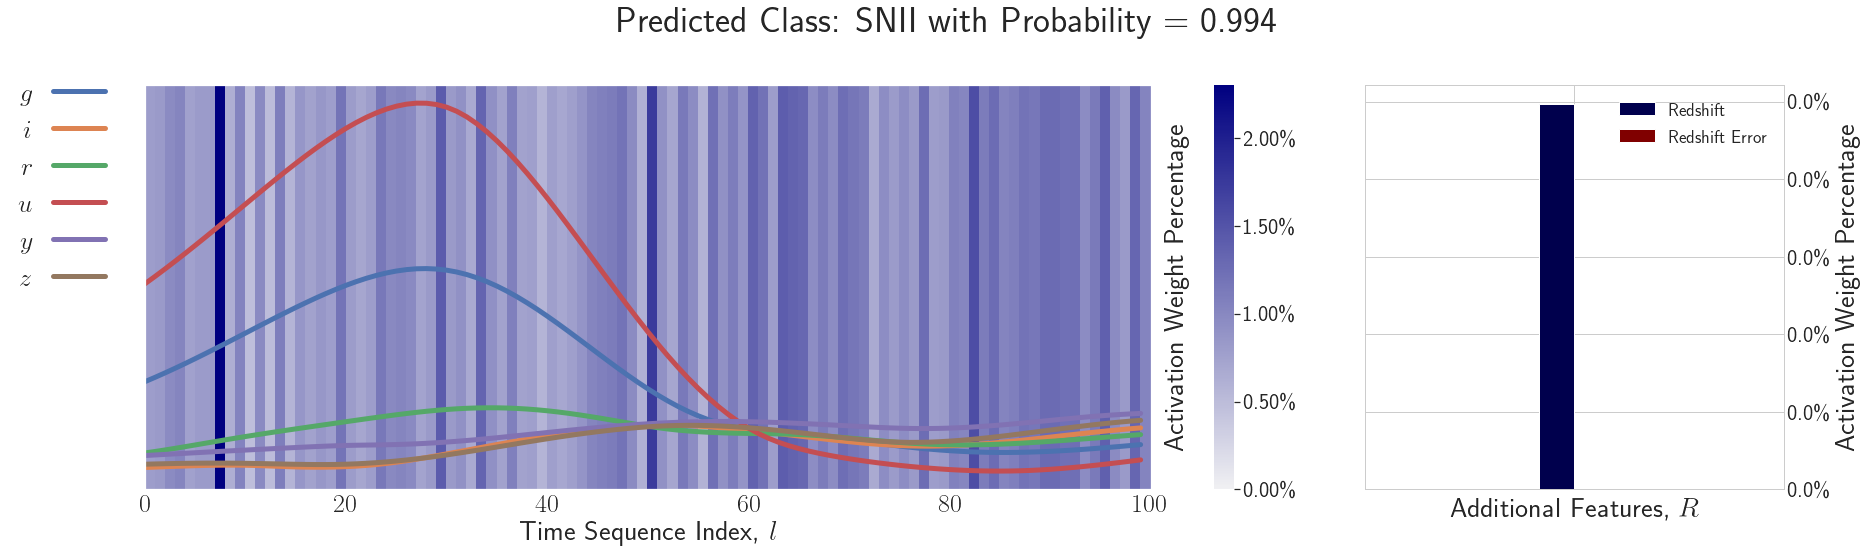

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99743325
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.008033406920731 0.014507152140141
MAX L: 0.02183173 79
SUM L: 0.97745955
SUM z: 0.022540558
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

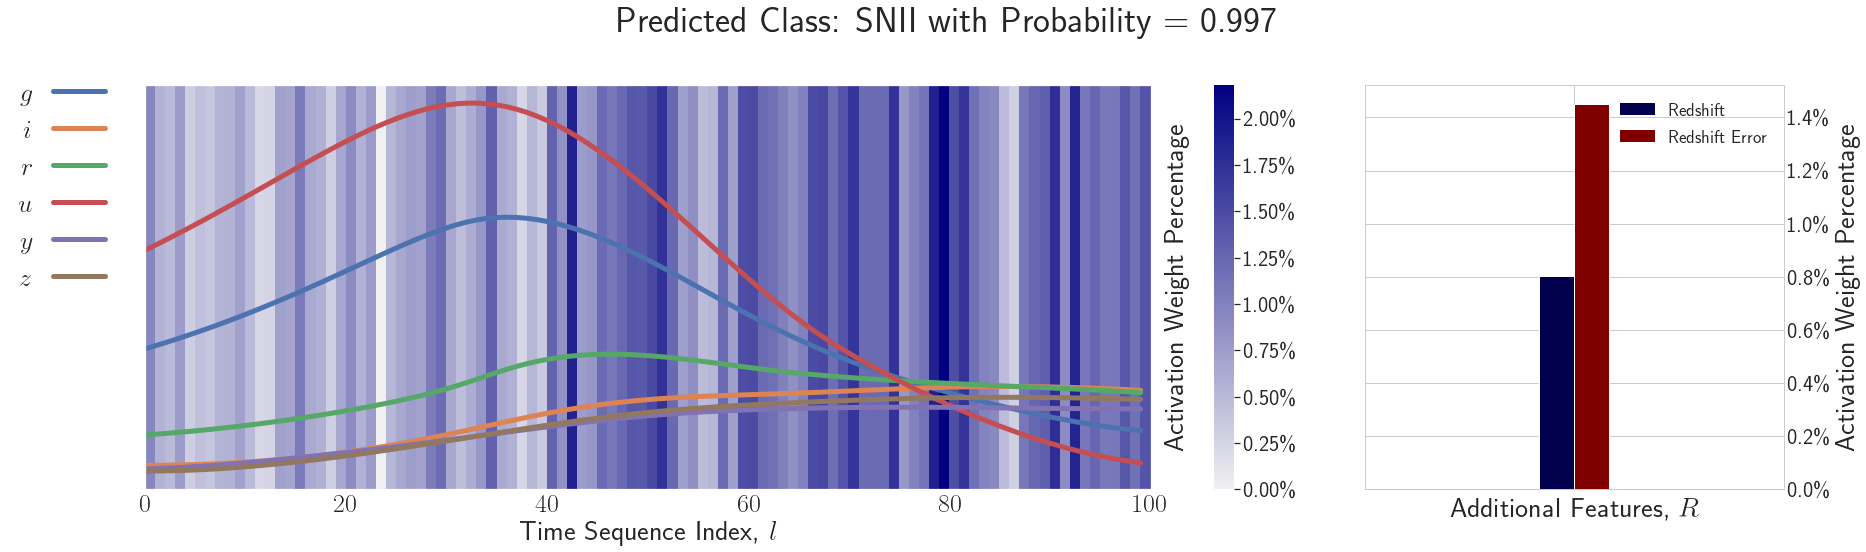

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.991096
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.39032555
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.64307326
[0.99999976]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.97723526
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.98370045
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.851798
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.4558092
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8622382
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6756951
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99725777
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.001997406128794 0.000000000000000
MAX L: 0.016479395 57
SUM L: 0.99800265
SUM z: 0.0019974061
SUM

<Figure size 1152x648 with 0 Axes>

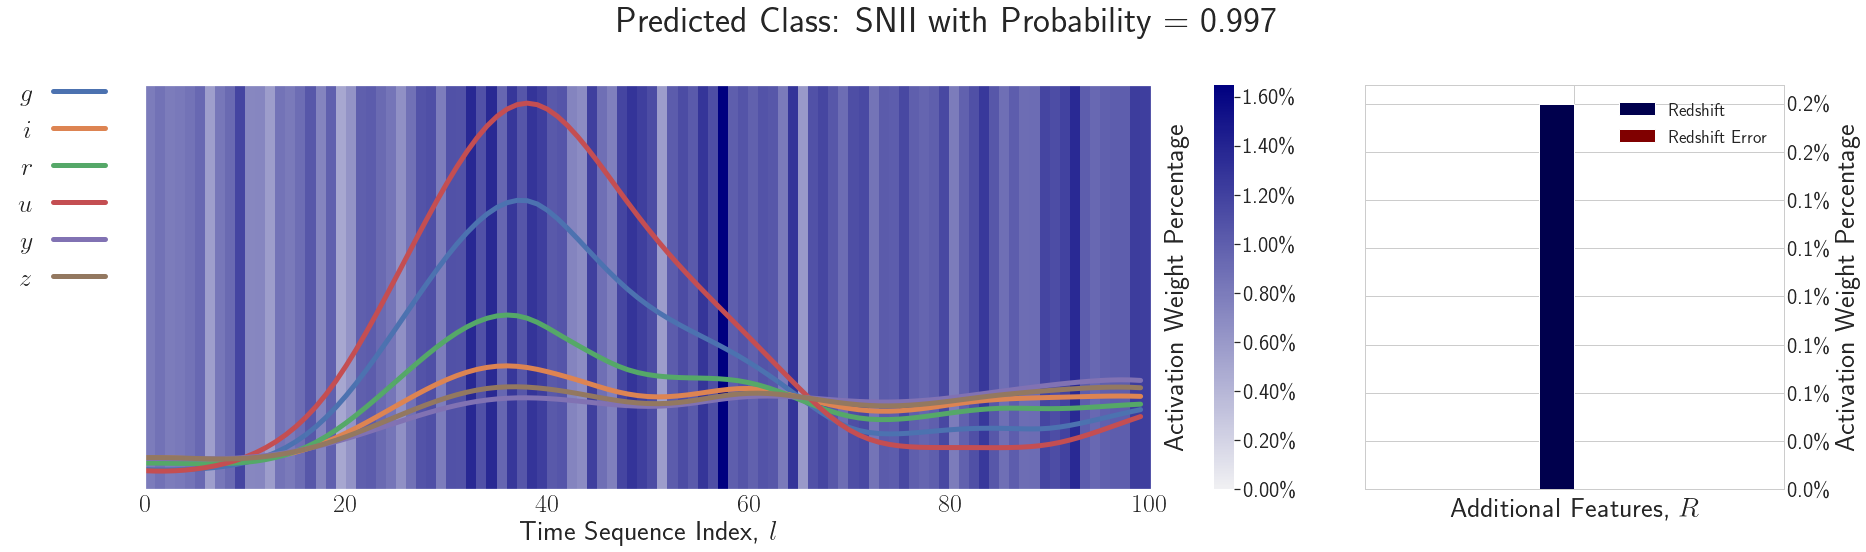

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.34474832
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.40533045
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9900849
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99463093
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.007961221039295 0.009636866860092
MAX L: 0.022968078 62
SUM L: 0.98240185
SUM z: 0.017598089
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

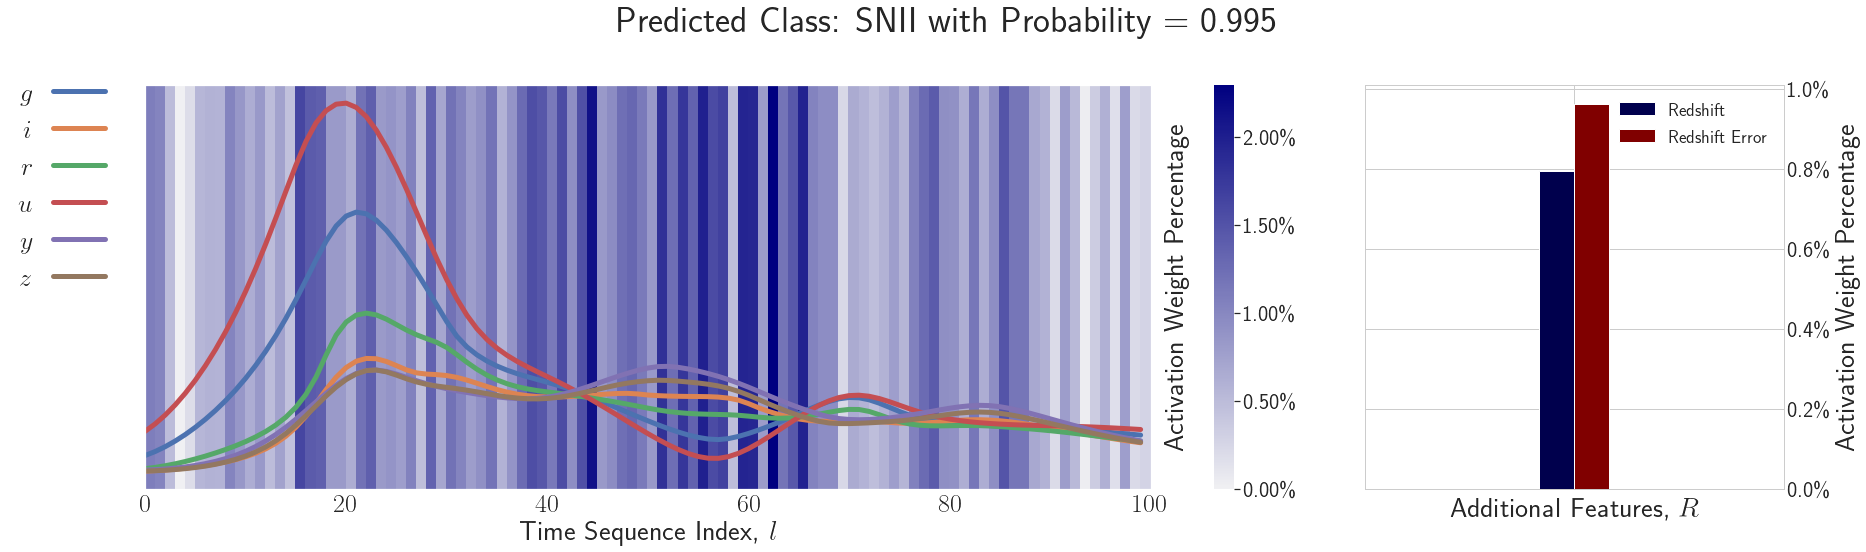

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.5885095
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.567031
[0.99999976]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.52048886
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9934354
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.000359661702532 0.000000000000000
MAX L: 0.018818012 78
SUM L: 0.99964035
SUM z: 0.0003596617
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

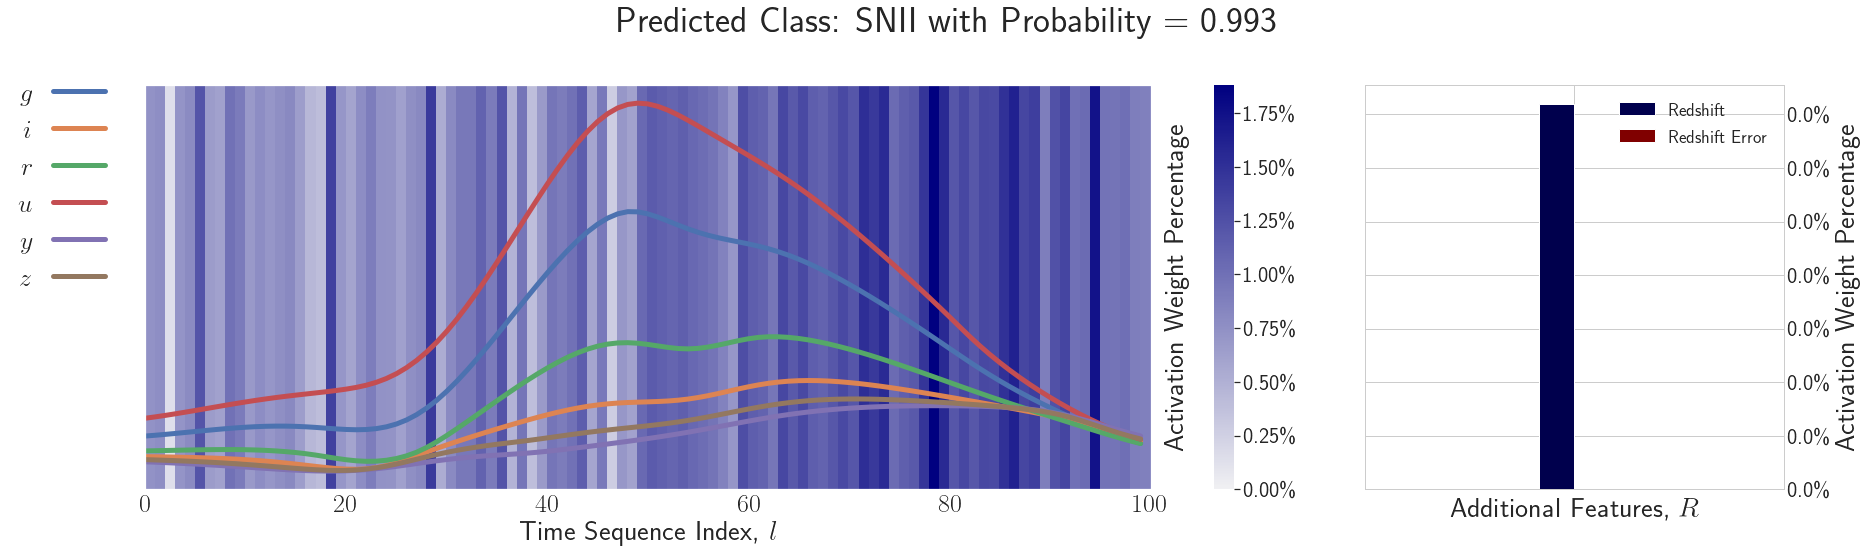

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.65450376
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9702922
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8966895
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.28011888
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.986311
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.97705907
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.47177702
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.77155584
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99905807
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.013206544332206 0.012971282936633
MAX L: 0.022688076 60
SUM L: 0.9738221
SUM z: 0.026177827
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

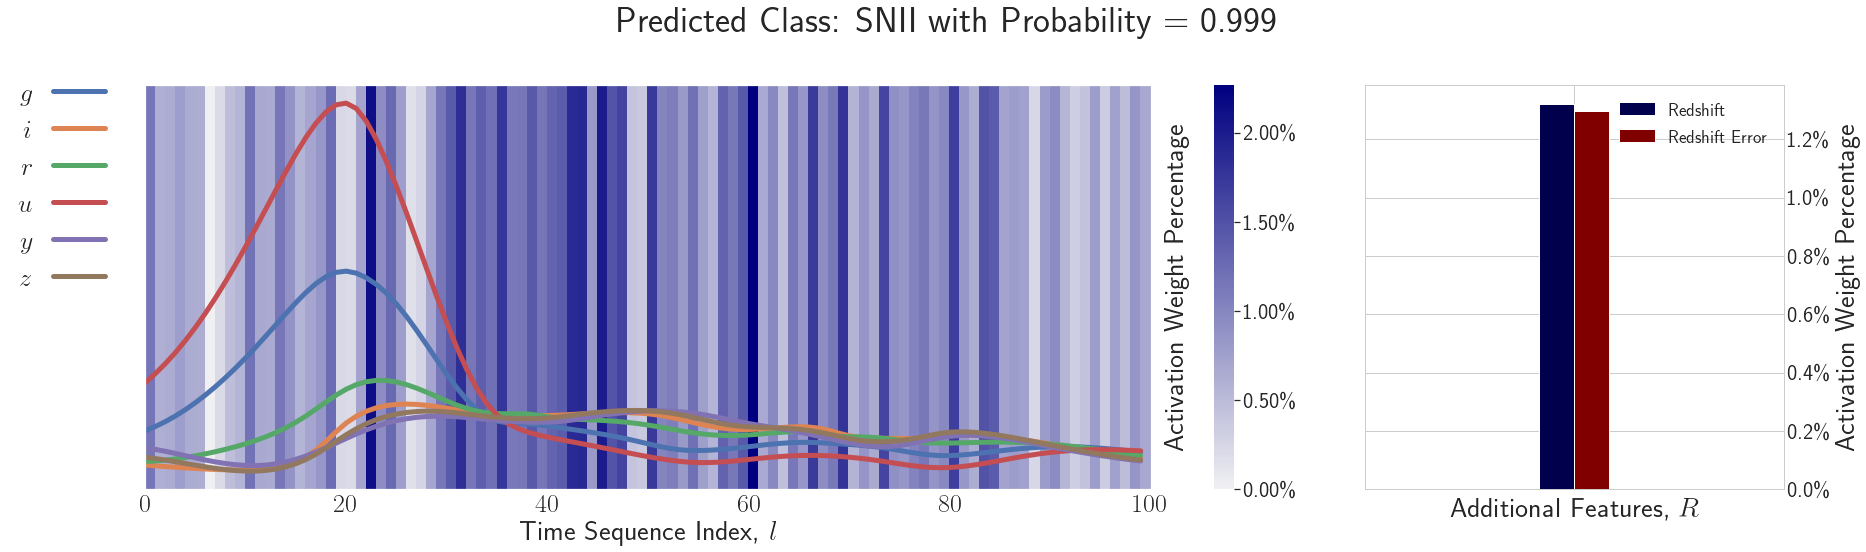

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.813323
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9882957
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.427554
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.96006817
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.979985
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9994906
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.003669218625873 0.003395808860660
MAX L: 0.019431036 50
SUM L: 0.992935
SUM z: 0.0070650275
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

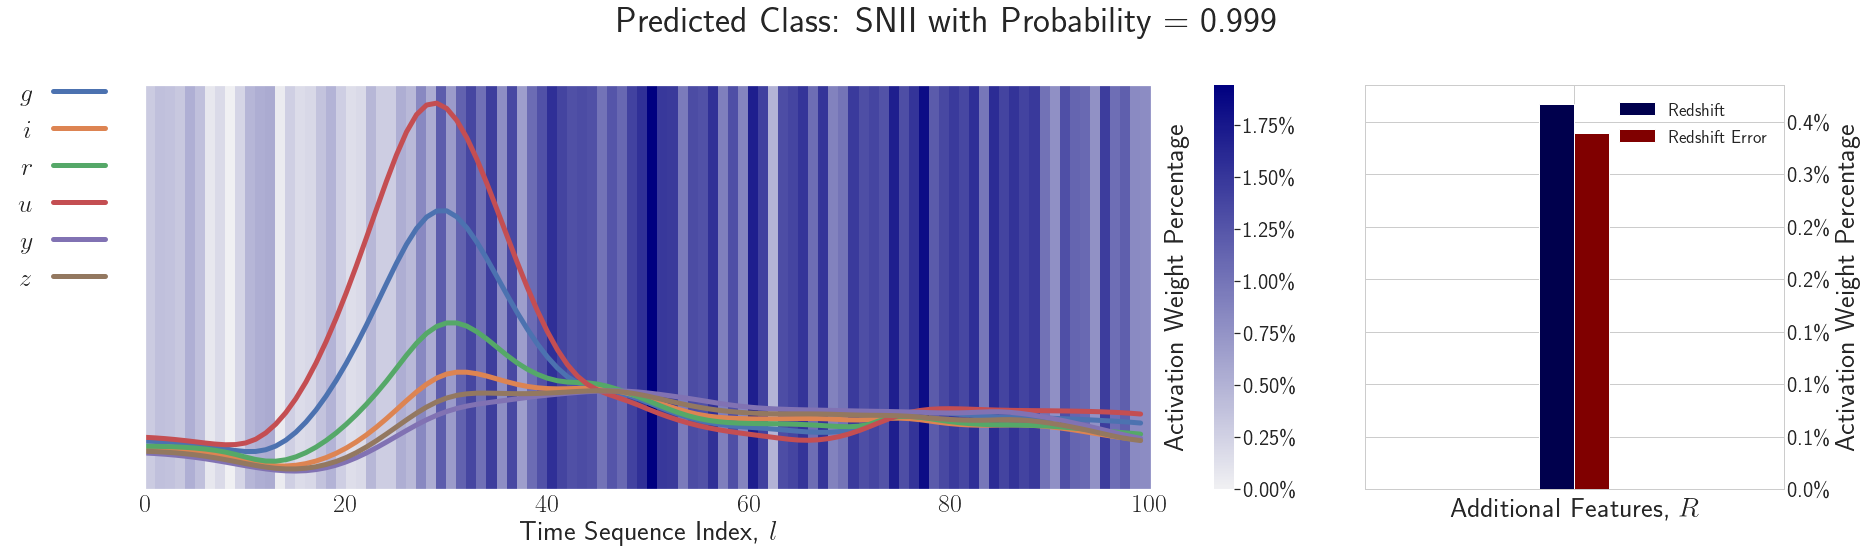

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9501952
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.98343796
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6896506
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.57595223
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.759891
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.7146982
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.73241705
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8541113
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.39235264
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9050386
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8352418
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability =

<Figure size 1152x648 with 0 Axes>

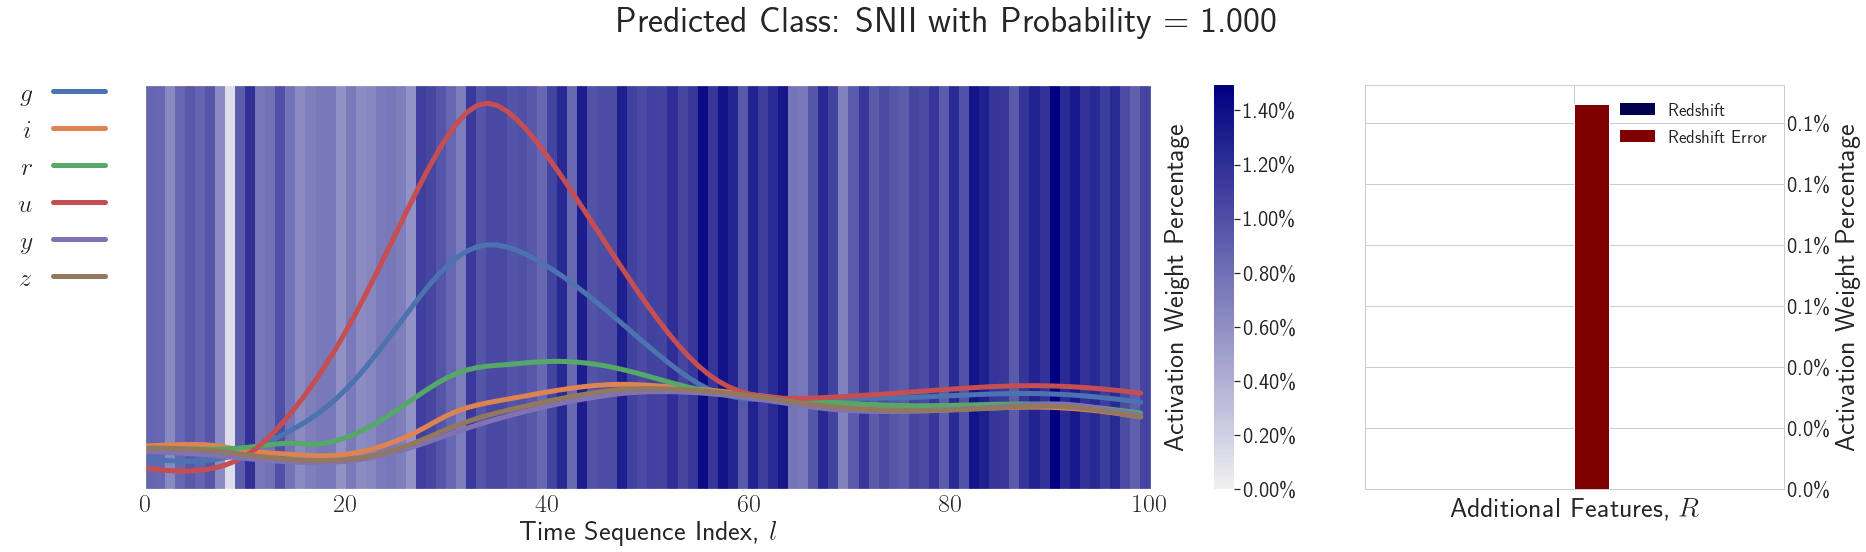

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9538742
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.7408641
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.29388776
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99864584
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.006578809116036 0.000782361952588
MAX L: 0.020721637 60
SUM L: 0.9926389
SUM z: 0.007361171
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

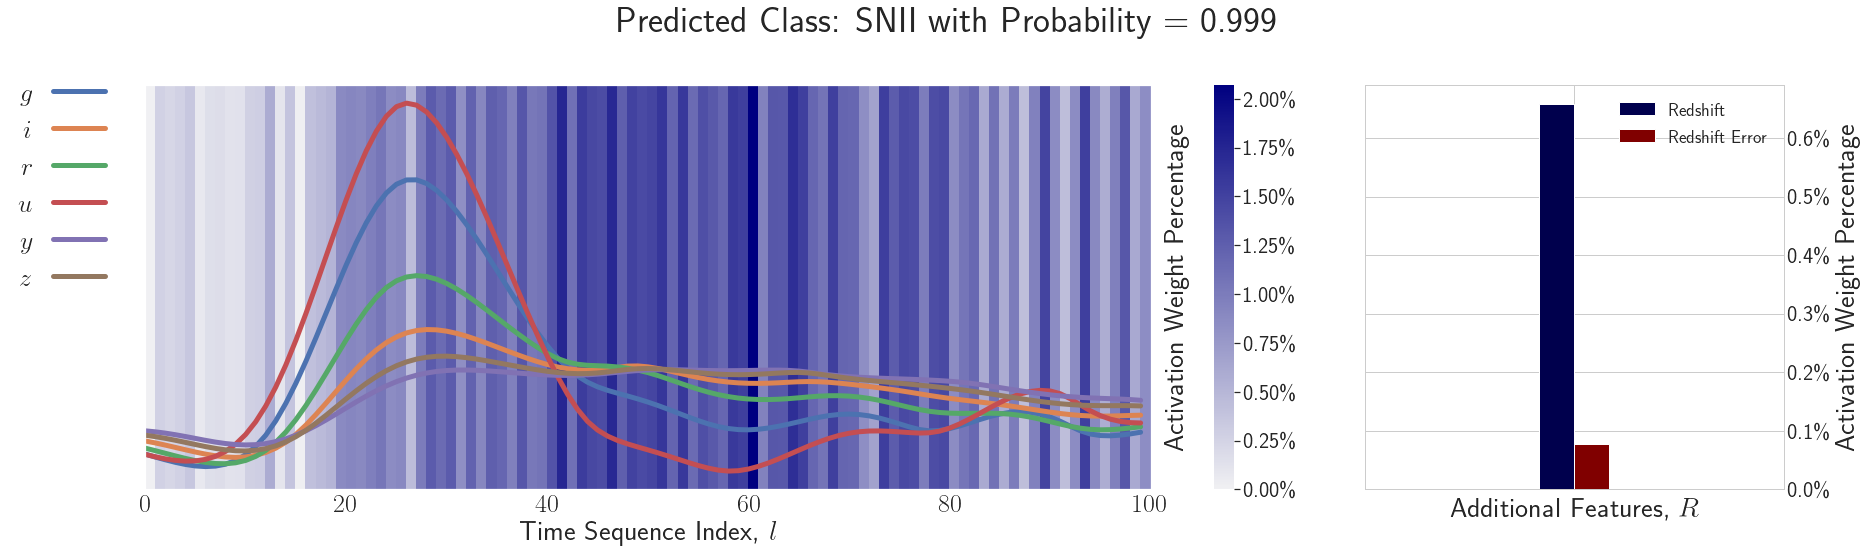

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.94532967
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9994254
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.012509624473751 0.012591576203704
MAX L: 0.017404854 43
SUM L: 0.9748987
SUM z: 0.0251012
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

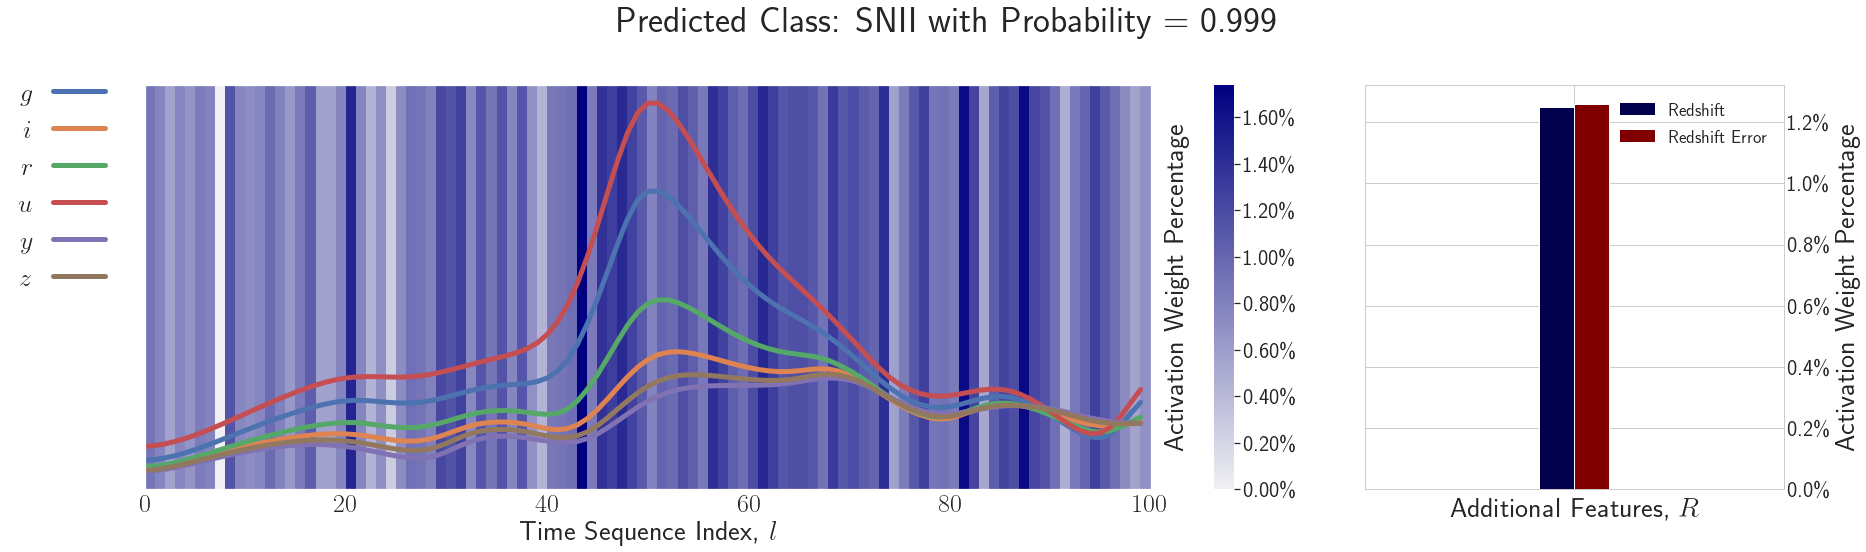

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.41005802
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.84262073
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.95791674
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.86991286
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9994399
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.011447723954916 0.007504868321121
MAX L: 0.016202178 61
SUM L: 0.98104733
SUM z: 0.018952593
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

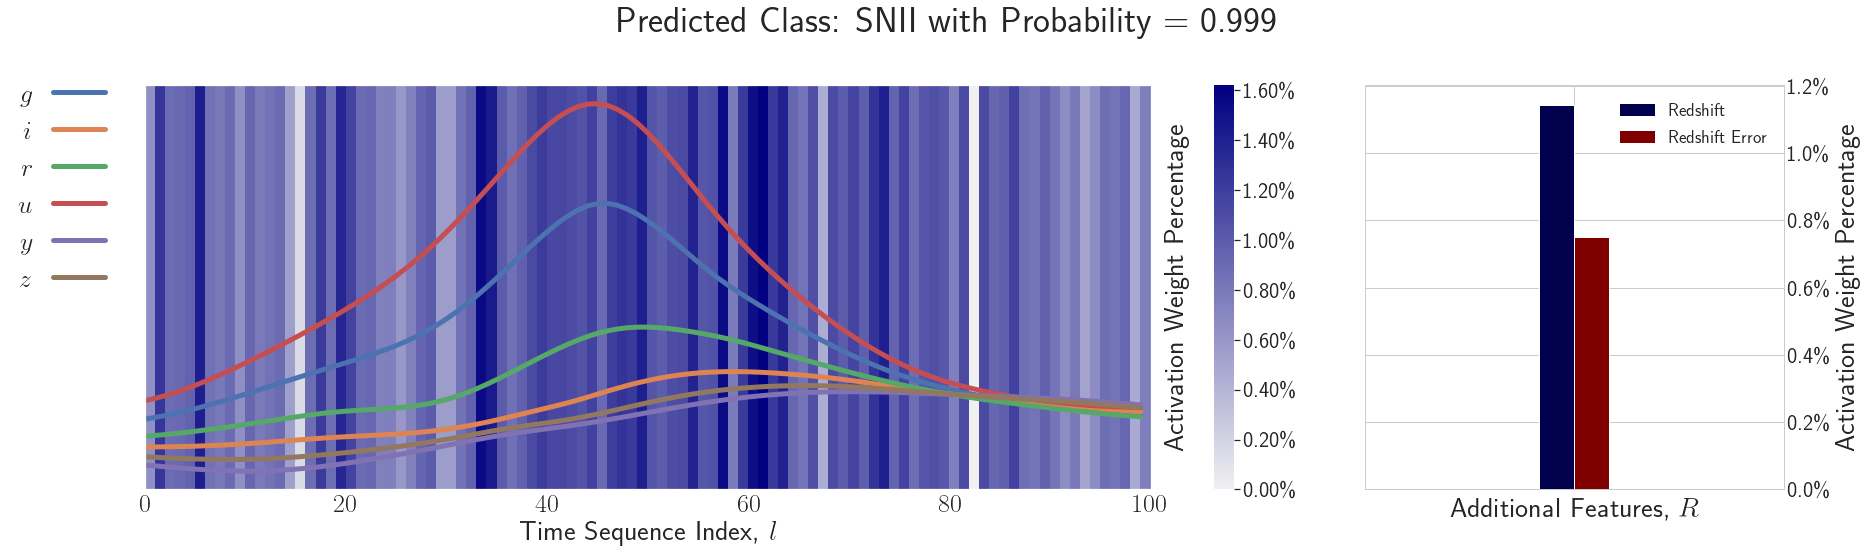

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8377554
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.494699
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8692138
[0.9999998]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.89274186
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.42228895
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.96823823
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.7021232
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.4191656
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6848225
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.40400663
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.83480144
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability 

<Figure size 1152x648 with 0 Axes>

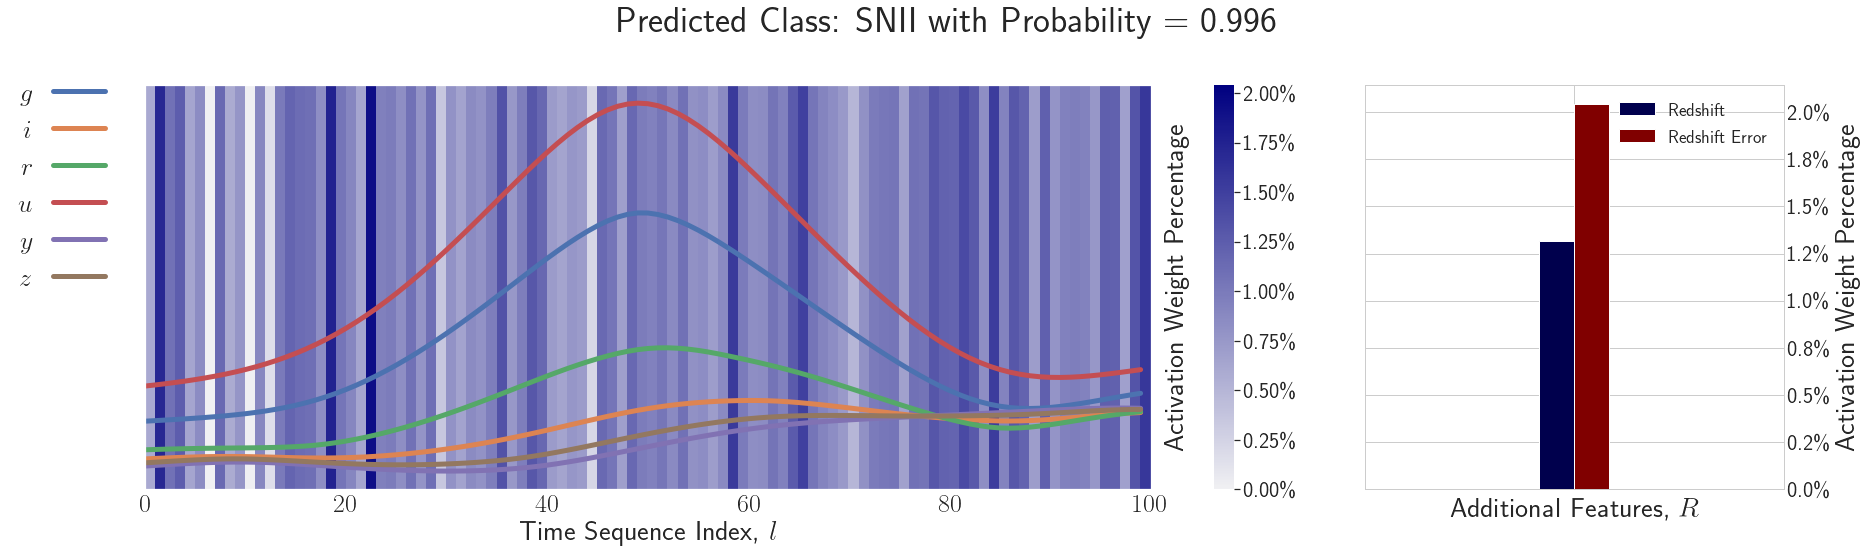

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9991702
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.012873246334493 0.012895273044705
MAX L: 0.018662753 84
SUM L: 0.9742315
SUM z: 0.025768518
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

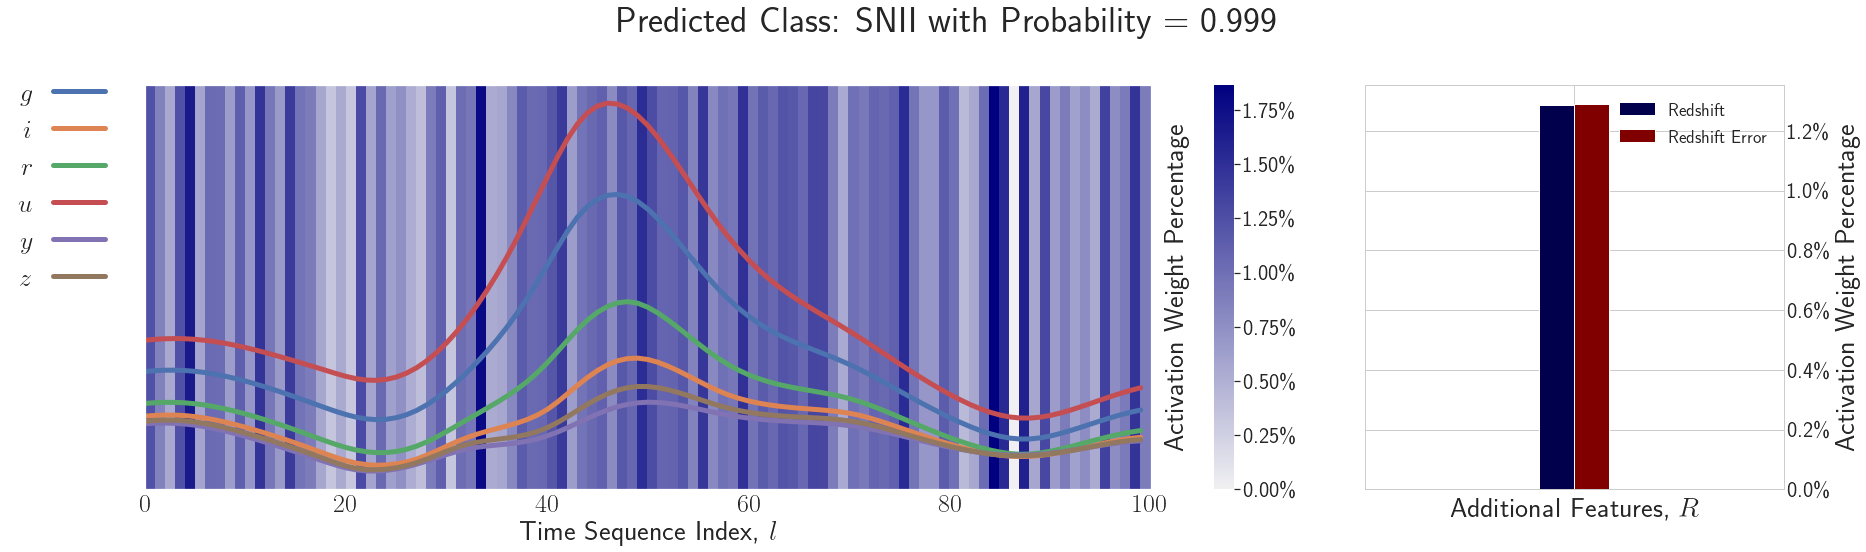

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99548703
[0.9999999]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.012985297478735 0.008777166716754
MAX L: 0.020782277 93
SUM L: 0.97823745
SUM z: 0.021762464
SUM CAM: 0.9999999
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

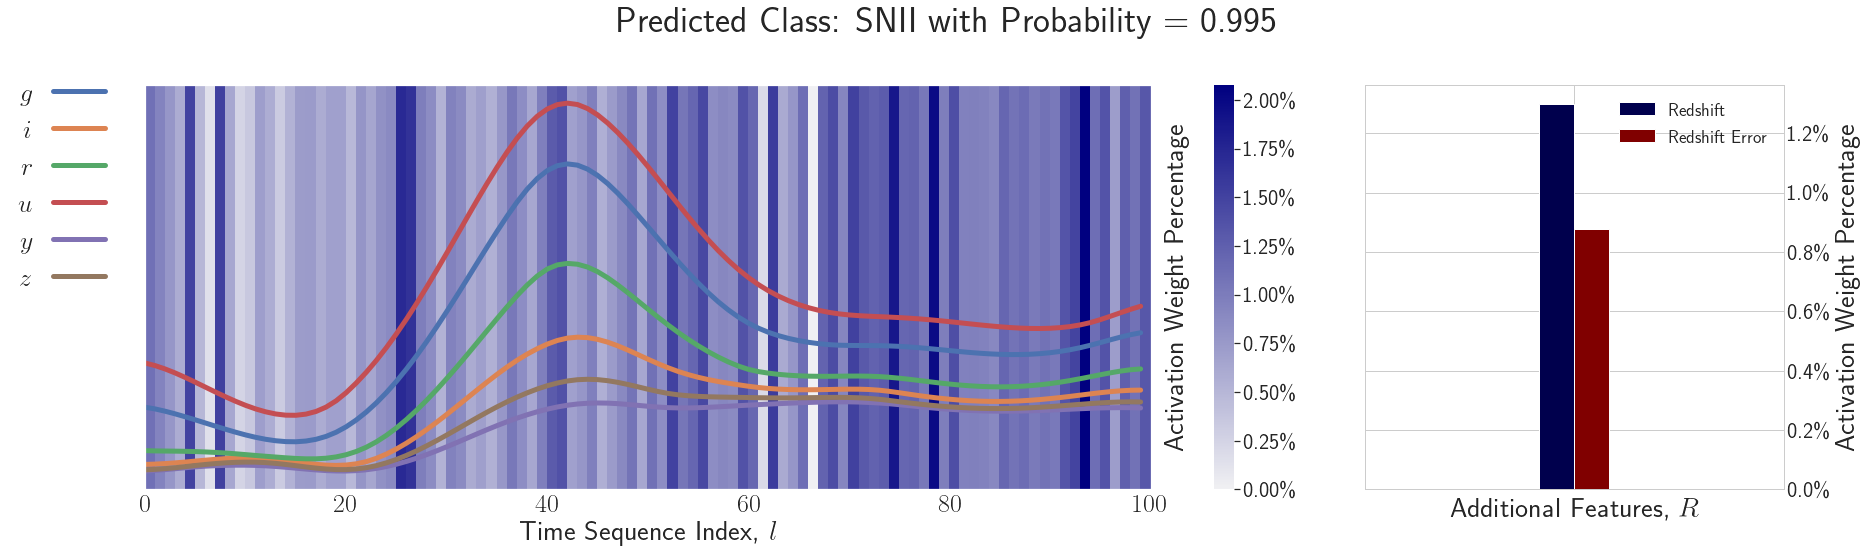

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.5372025
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9521677
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9572129
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8286
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9844248
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99978656
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.013920836150646 0.014419368468225
MAX L: 0.020380825 92
SUM L: 0.97165996
SUM z: 0.028340206
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

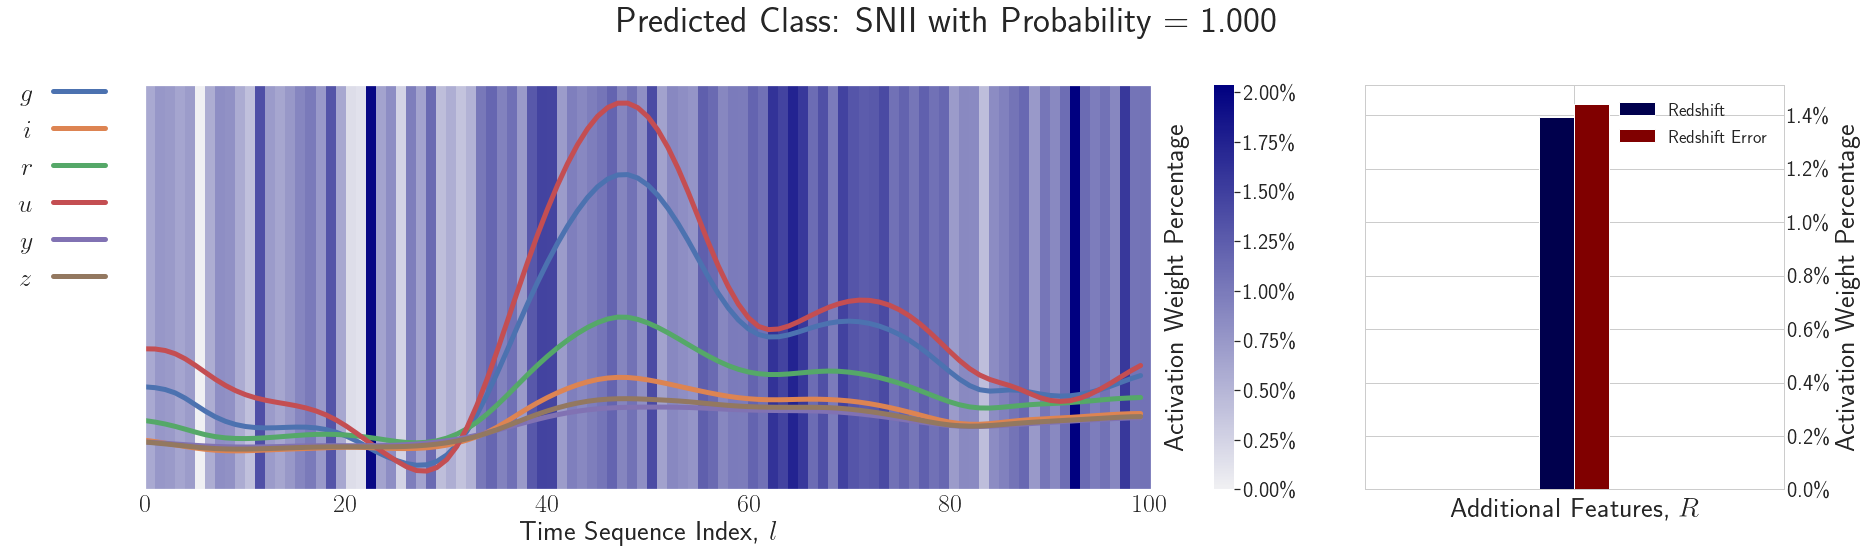

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9972228
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.009636794216931 0.011196245439351
MAX L: 0.023830567 5
SUM L: 0.979167
SUM z: 0.02083304
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

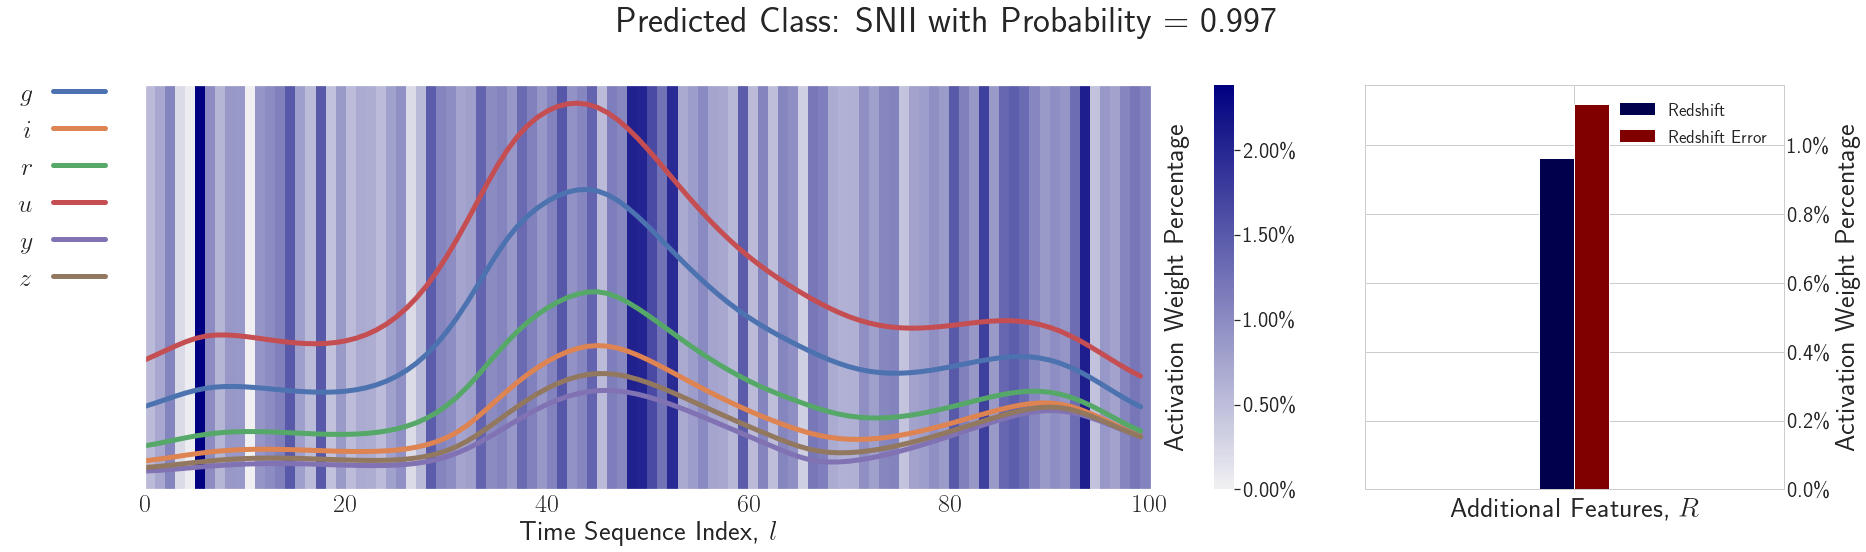

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8860502
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9034205
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.5518749
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.52333283
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99607664
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.008639262057841 0.005823723506182
MAX L: 0.020980563 65
SUM L: 0.98553705
SUM z: 0.014462985
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

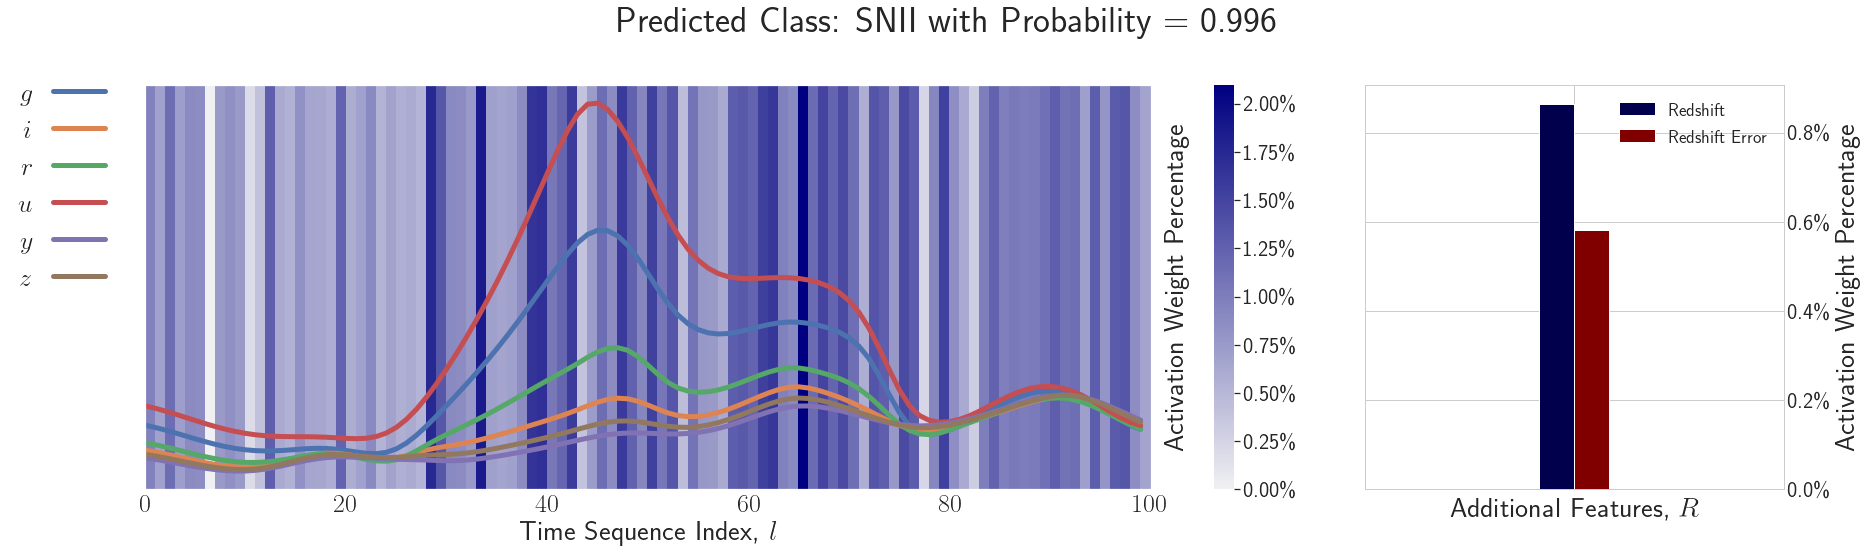

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.87226915
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.47709426
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.59345704
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9997273
[0.9999998]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.003669872414321 0.000000000000000
MAX L: 0.013112181 63
SUM L: 0.99632996
SUM z: 0.0036698724
SUM CAM: 0.9999998
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

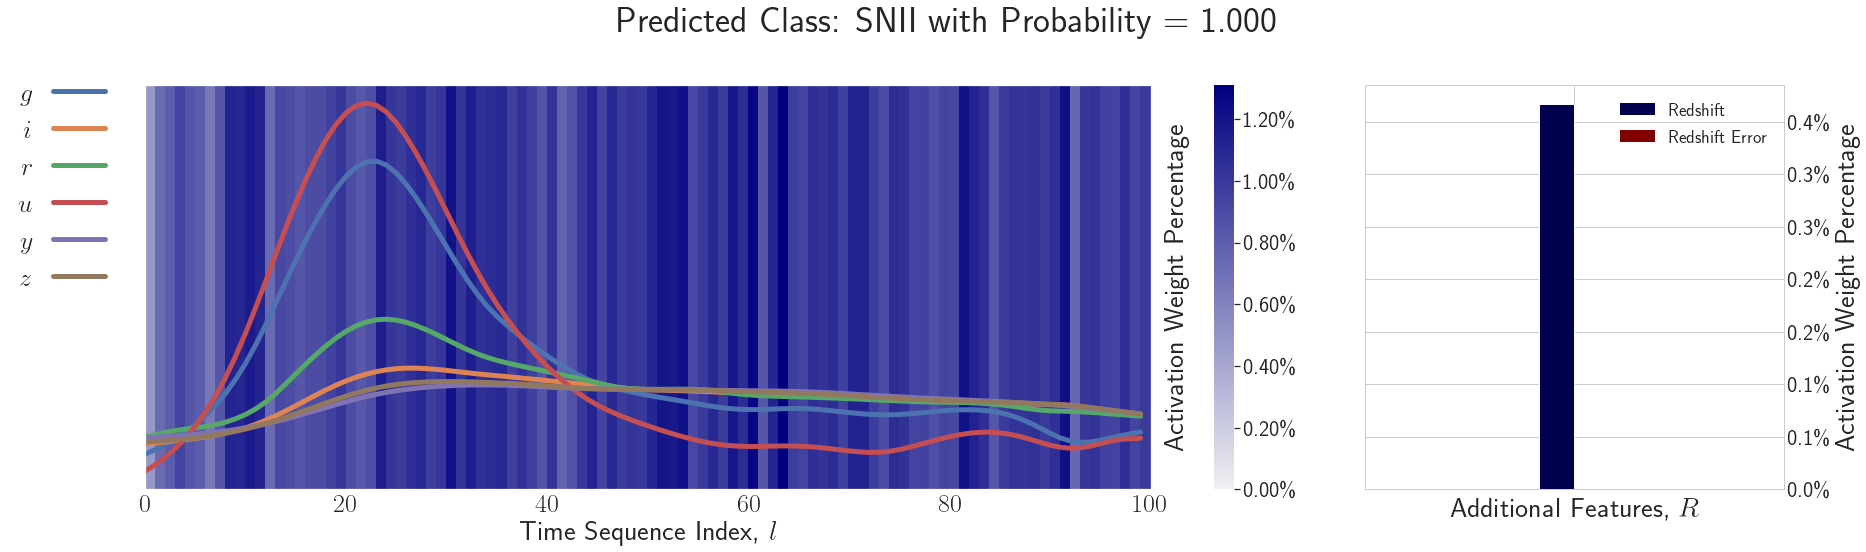

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8394424
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8467291
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.8137759
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9448976
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.90264
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.98149157
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9841866
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.57312745
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.7769377
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.7921702
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.59178627
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predict

<Figure size 1152x648 with 0 Axes>

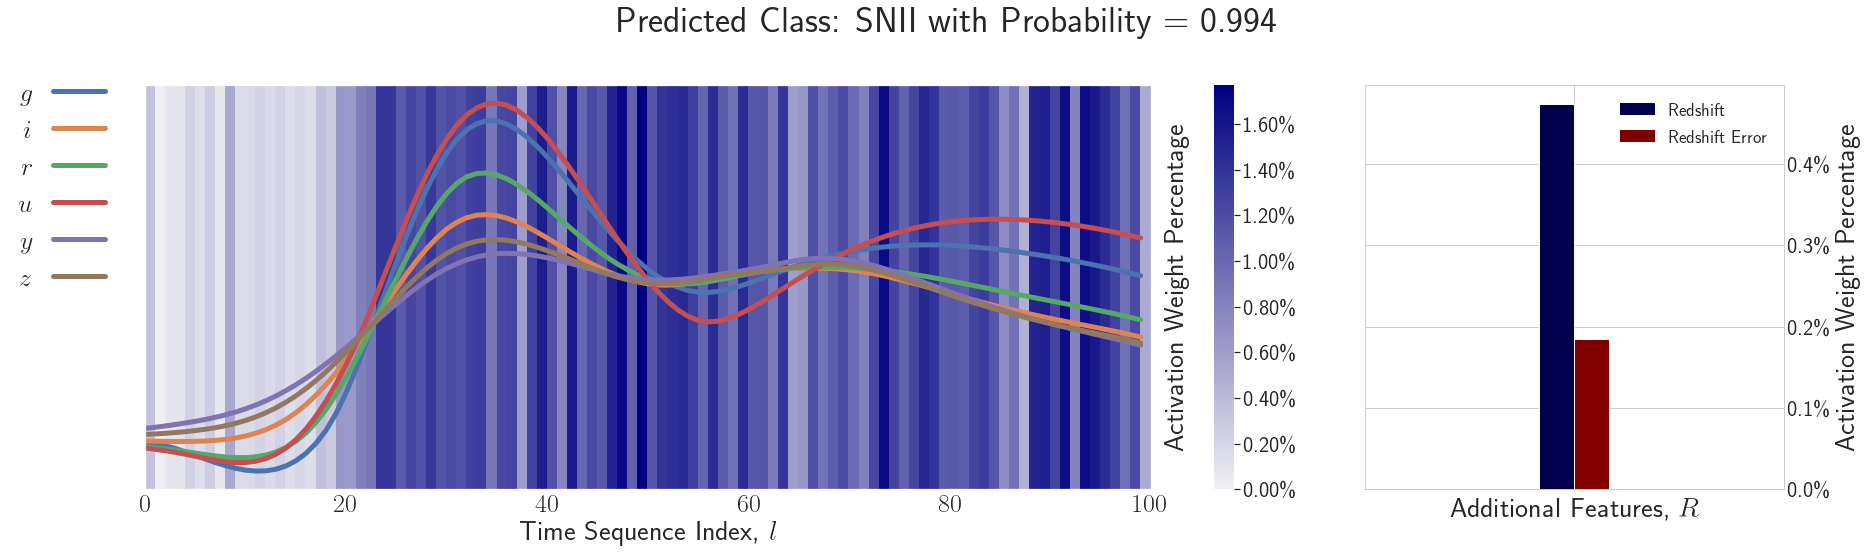

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9771005
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9863687
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.7040939
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6352704
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9832825
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9959676
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.011061984114349 0.008512063883245
MAX L: 0.02115282 66
SUM L: 0.98042595
SUM z: 0.019574048
SUM CAM: 1.0
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

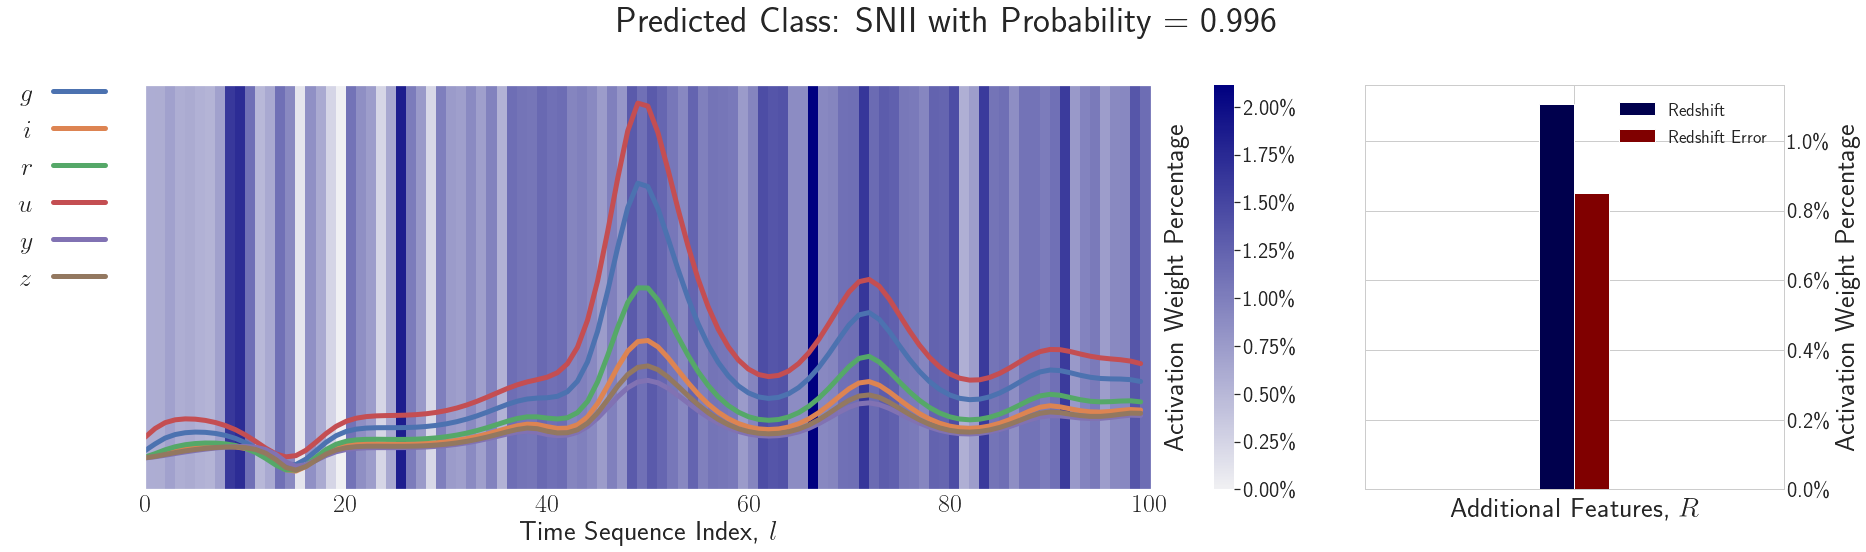

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.90963906
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9938678
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.000000000000000 0.001571762724780
MAX L: 0.017757732 65
SUM L: 0.99842817
SUM z: 0.0015717627
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

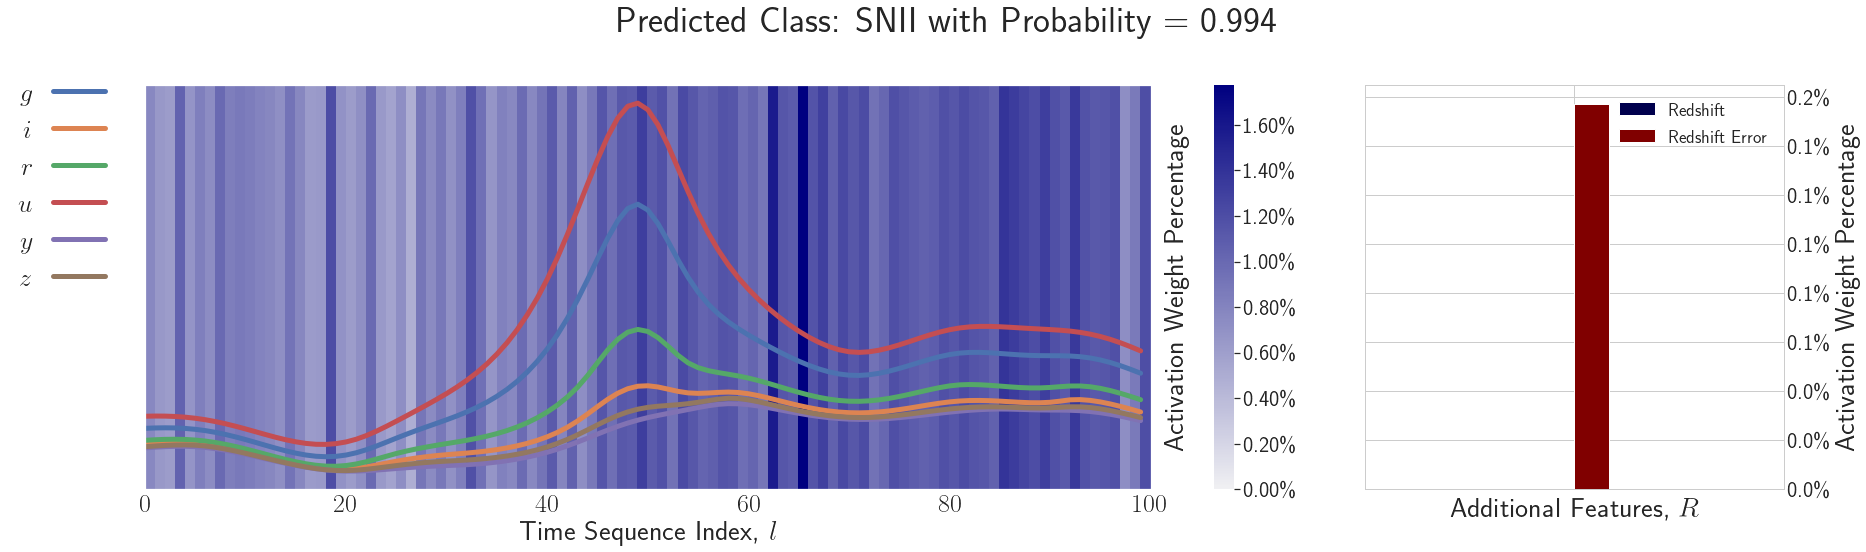

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9312066
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.44600877
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.3326786
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9884947
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.79243225
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6411301
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6811718
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6141803
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.4826172
[1.]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.4992075
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.99672145
[1.]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.00429703

<Figure size 1152x648 with 0 Axes>

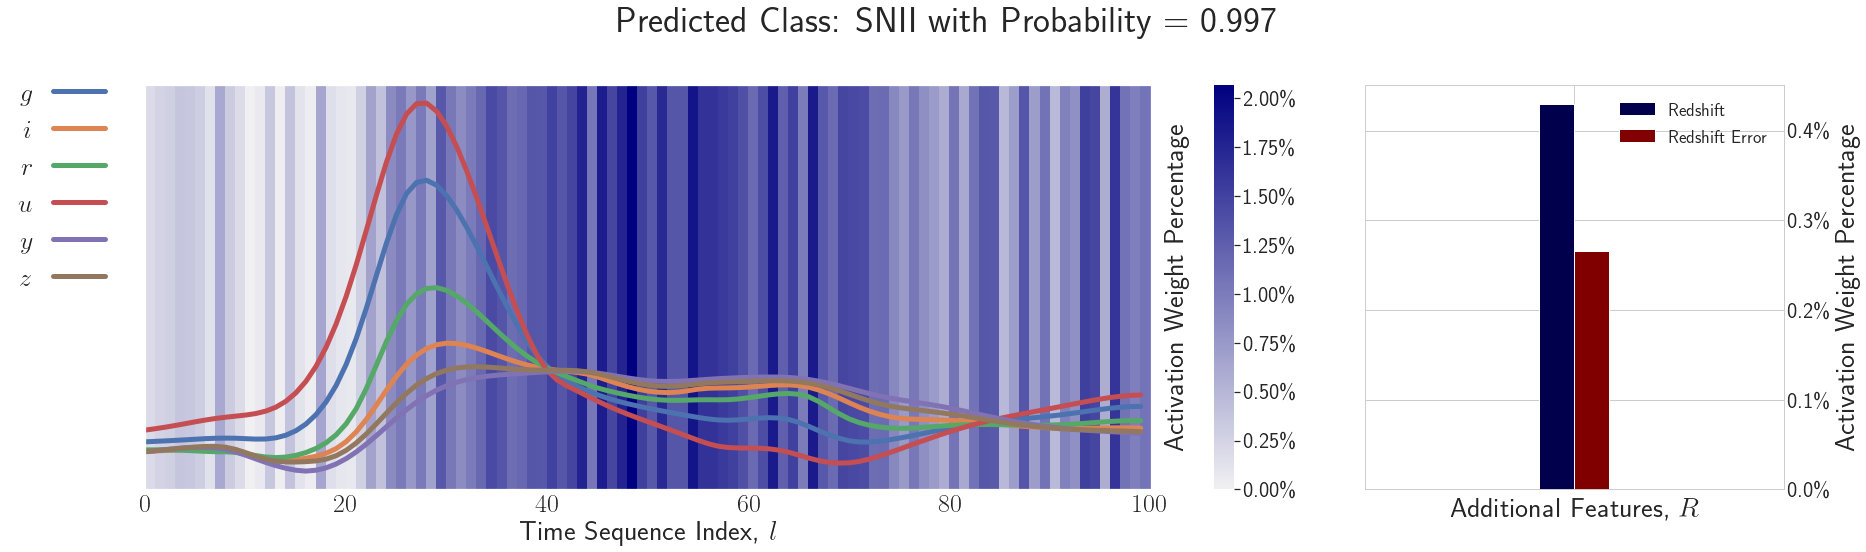

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.40886292
[0.9999999]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.6616049
[1.0000001]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.997575
[1.0000001]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.006284547969699 0.009550532326102
MAX L: 0.022397224 30
SUM L: 0.984165
SUM z: 0.01583508
SUM CAM: 1.0000001
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

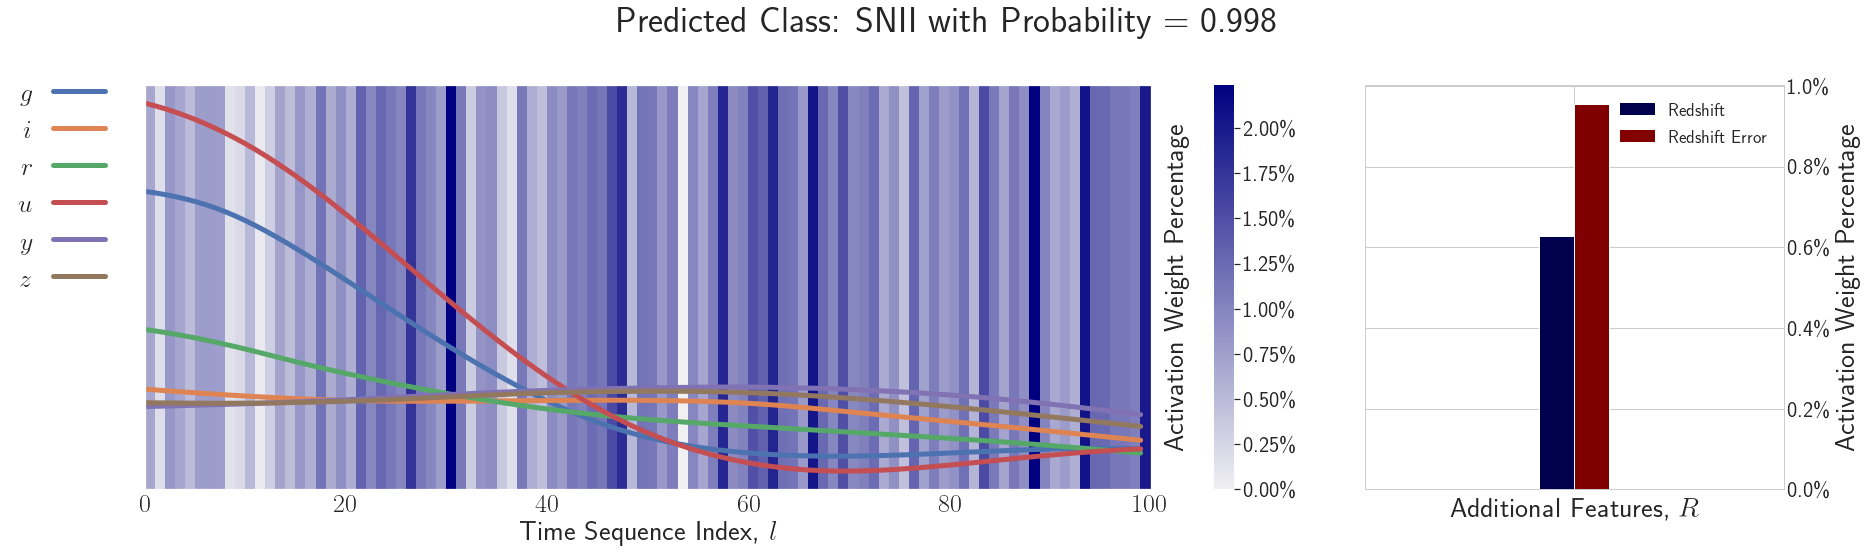

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9991948
[0.99999994]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.000000000000000 0.000615977798589
MAX L: 0.01828553 57
SUM L: 0.999384
SUM z: 0.0006159778
SUM CAM: 0.99999994
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

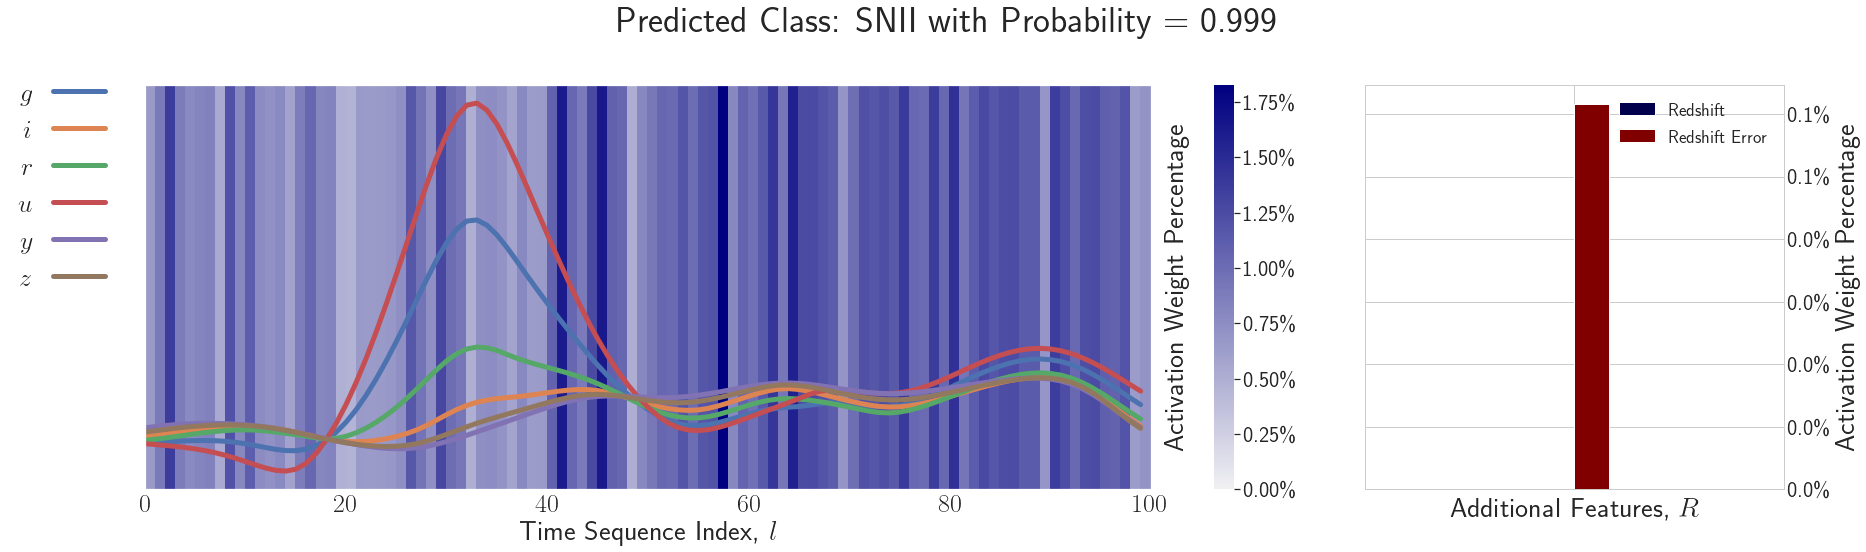

(102,)
(1, 102)
Predicted Class = 3, Probability = 0.97433066
[0.99999994]
(1, 100) (1, 2)
(102,)
(1, 102)
Predicted Class = 3, Probability = 0.9984792
[0.9999998]
(1, 100) (1, 2)
           redshift    redshift-error
0 0.014885070733726 0.006458959076554
MAX L: 0.026613215 89
SUM L: 0.9786558
SUM z: 0.02134403
SUM CAM: 0.9999998
MIN CAM: 0.0


<Figure size 1152x648 with 0 Axes>

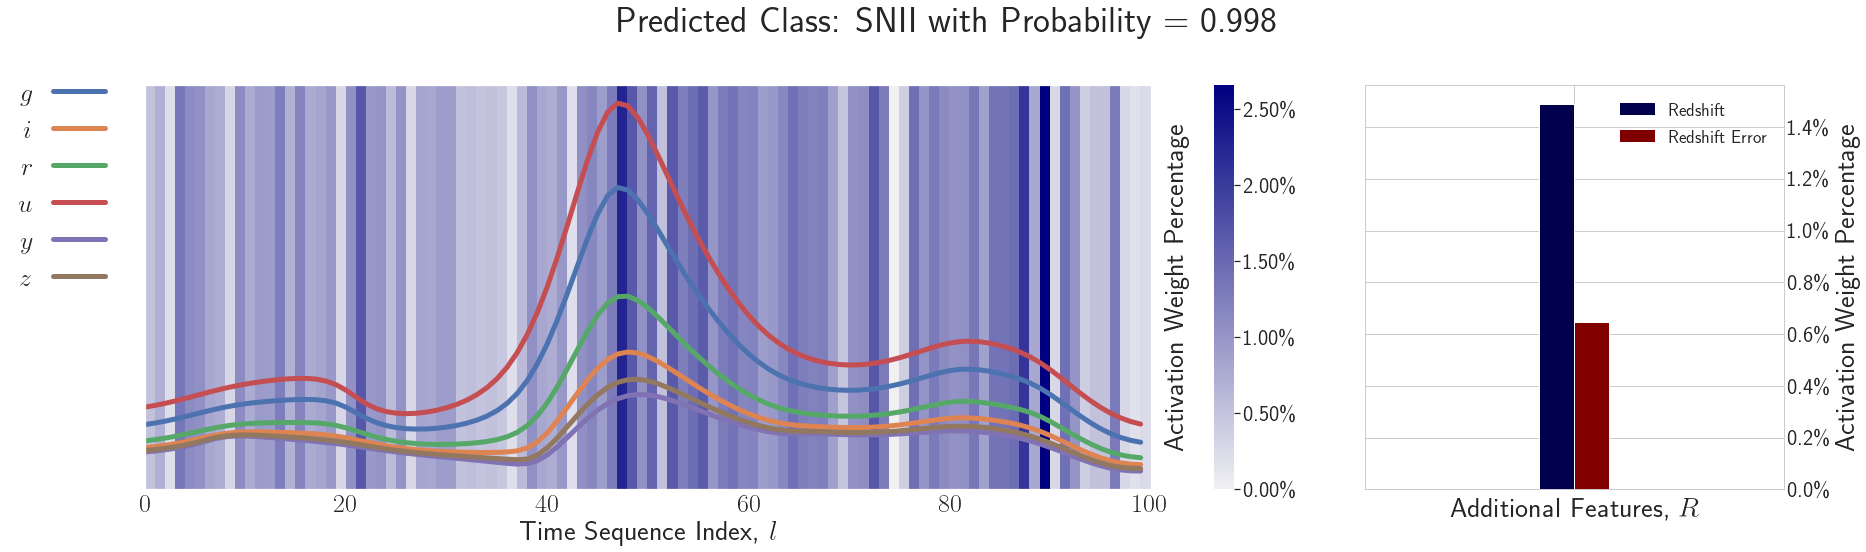

<Figure size 1152x648 with 0 Axes>

In [53]:
# Attempt to show 40 examples of SNIa
np.random.seed(RANDOM_SEED)
show_maps(desired_class=class_names.index("SNII"), num_maps=50)

# Make CAMs for all classes with x num_maps attempts
# make_cams(40)